In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


In [4]:
pdb='./RegA_MYS_noCorN.pdb'
trajectory='./RegA_MYS_noCorN.xtc'
outdir='./outdir_MYS'
if not os.path.exists('outdir_MYS'):
    os.makedirs('outdir_MYS')
    
print("outdir_MYS:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir_MYS: ./outdir_MYS
pdb: ./RegA_MYS_noCorN.pdb
trjaectory: ./RegA_MYS_noCorN.xtc


In [5]:
trj = md.load(trajectory, top=pdb,stride=5)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [6]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 4245

Number of residues: 255

Number of frames: 6000

Starting frame: 0

Last frame: 6000

sequence:  [ASN1, MET2, LEU3, VAL4, LEU5, LYS6, LYS7, ILE8, ARG9, PHE10, TYR11, ASN12, CYS13, ALA14, ILE15, ILE16, HIS17, LEU18, ARG19, ASP20, ALA21, GLN22, LEU23, LEU24, ILE25, ARG26, THR27, LYS28, ASP29, GLY30, GLN31, THR32, LEU33, ASN34, ILE35, PRO36, PRO37, GLU38, SER39, LEU40, CYS41, TYR42, VAL43, GLU44, LYS45, ASN46, THR47, VAL48, MET49, ASP50, VAL51, ALA52, LEU53, LYS54, VAL55, LEU56, GLY57, SER58, GLY59, VAL60, PRO61, TYR62, GLU63, VAL64, TYR65, HIS66, VAL67, ASP68, SER69, ASP70, VAL71, LEU72, ARG73, CYS74, ILE75, CYS76, LYS77, VAL78, MET79, GLU80, PRO81, LEU82, LEU83, LEU84, ASP85, PRO86, GLN87, ARG88, VAL89, ASN90, HIS91, THR92, ARG93, ARG94, LYS95, ILE96, PHE97, THR98, CYS99, ALA100, VAL101, ASP102, GLU103, THR104, ASP105, THR106, ARG107, ILE108, PHE109, LYS110, ARG111, LEU112, THR113, GLY114, SER115, ASN116, VAL117, PRO118, GLN119, HIS120, ARG121, 

In [6]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)
residue_id

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

Here I evaluate the secondary structure atributes of RegA with MYS bound.

In [38]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
dssp=md.compute_dssp(trj,simplified=True)
dssp

array([['C', 'E', 'E', ..., 'C', 'C', 'NA'],
       ['C', 'E', 'E', ..., 'H', 'C', 'NA'],
       ['C', 'E', 'E', ..., 'C', 'C', 'NA'],
       ...,
       ['C', 'C', 'C', ..., 'C', 'C', 'NA'],
       ['C', 'E', 'E', ..., 'C', 'C', 'NA'],
       ['C', 'E', 'E', ..., 'C', 'C', 'NA']], dtype='<U2')

Helix fractions saved to ./outdir_MYS\RegA_MYS_noCorN_helix_fractions.dat
Sheet fractions saved to ./outdir_MYS\RegA_MYS_noCorN_sheet_fractions.dat


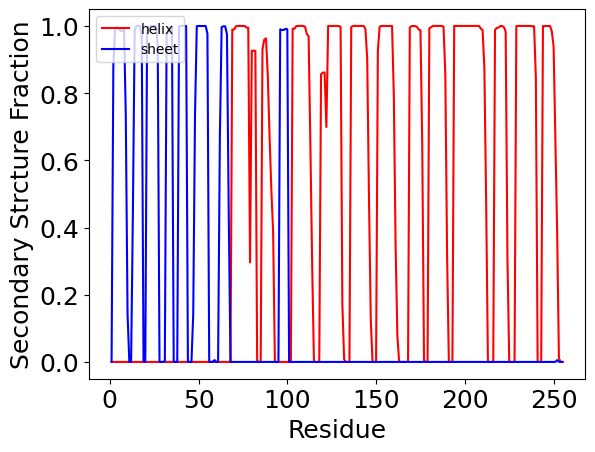

In [39]:
dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(residue_num,Hprop,c='r',label='helix')
plt.plot(residue_num,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)

# Save helix fractions to a .dat file
helix_data = np.column_stack((residue_num, Hprop))
outfile_helix = os.path.join(outdir, 'RegA_MYS_noCorN_helix_fractions.dat')
np.savetxt(outfile_helix, helix_data, header='Residue HelixFraction', comments='')
print(f"Helix fractions saved to {outfile_helix}")

# Save sheet fractions to a .dat file
sheet_data = np.column_stack((residue_num, Eprop))
outfile_sheet = os.path.join(outdir, 'RegA_MYS_noCorN_sheet_fractions.dat')
np.savetxt(outfile_sheet, sheet_data, header='Residue SheetFraction', comments='')
print(f"Sheet fractions saved to {outfile_sheet}")

SS: H [ 69  70  71  72  73  74  75  76  77  78 103 104 105 106 107 108 109 110
 111 112 123 124 125 126 127 128 129 130 136 137 138 139 140 141 142 143
 144 145 151 152 153 154 155 156 157 158 159 169 170 171 172 173 174 175
 180 181 182 183 184 185 186 187 188 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 217 218 219 220 221 222 223 229 230 231
 232 233 234 235 236 237 238 239 244 245 246 247 248 249 250]
SS: E [  3   4   5   6   7   8  14  15  16  17  18  21  22  23  24  25  26  27
  32  33  34  35  39  40  41  42  43  49  50  51  52  53  54  55  63  64
  65  66  96  97  98  99 100]
SS: I []
SS: G [80 81 82]
SS: B []
SS: T [ 28  29 132 177 191 225]
SS: S [ 12  19  20  37  38  59  95 165 227 241 242]
SS:   [  1  31  36  44  56  68  83  85  94 101 102 118 149 150 166 167 168 179
 192 193 213 216 226 228 243 253 254]


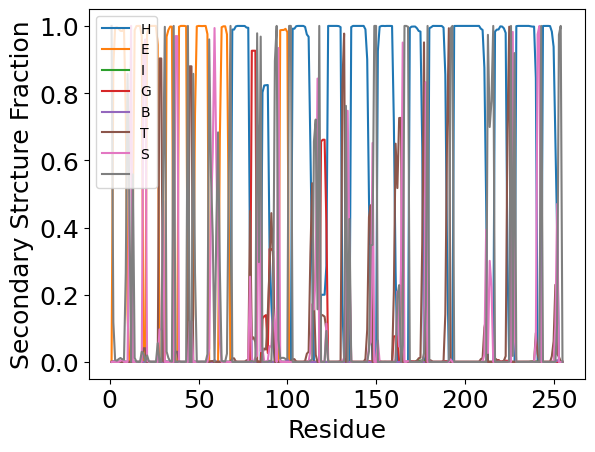

In [40]:
dssp_full=md.compute_dssp(trj,simplified=False)

def dssp_convert_type(dssp,type):
 dsspS=np.copy(dssp)
 dsspS[dsspS!=type]=0                                                                                      
 dsspS[dsspS==type]=1   # you could do this with an if as well                                                                                   
 dsspS=dsspS.astype(int)
 TotalS=np.sum(dsspS,axis=1) 
 Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS) 
 return Sprop

for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


SS: H [ 69  70  71  72  73  74  75  76  77  78 103 104 105 106 107 108 109 110
 111 112 123 124 125 126 127 128 129 130 136 137 138 139 140 141 142 143
 144 145 151 152 153 154 155 156 157 158 159 169 170 171 172 173 174 175
 180 181 182 183 184 185 186 187 188 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 217 218 219 220 221 222 223 229 230 231
 232 233 234 235 236 237 238 239 244 245 246 247 248 249 250]
SS: E [  3   4   5   6   7   8  14  15  16  17  18  21  22  23  24  25  26  27
  32  33  34  35  39  40  41  42  43  49  50  51  52  53  54  55  63  64
  65  66  96  97  98  99 100]
SS: I []
SS: G [80 81 82]
SS: B []
SS: T [ 28  29 132 177 191 225]
SS: S [ 12  19  20  37  38  59  95 165 227 241 242]
SS:   [  1  31  36  44  56  68  83  85  94 101 102 118 149 150 166 167 168 179
 192 193 213 216 226 228 243 253 254]


(1.0, 149.0)

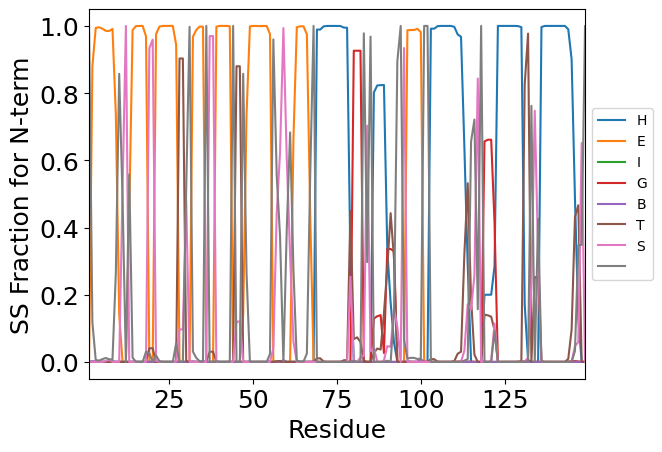

In [41]:
#Zoom in on the N-terminal domain
for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Residue', size=18)
plt.ylabel('SS Fraction for N-term', size=18)
plt.tick_params(labelsize=18)
plt.xlim(1,149)

SS: H [ 69  70  71  72  73  74  75  76  77  78 103 104 105 106 107 108 109 110
 111 112 123 124 125 126 127 128 129 130 136 137 138 139 140 141 142 143
 144 145 151 152 153 154 155 156 157 158 159 169 170 171 172 173 174 175
 180 181 182 183 184 185 186 187 188 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 217 218 219 220 221 222 223 229 230 231
 232 233 234 235 236 237 238 239 244 245 246 247 248 249 250]
SS: E [  3   4   5   6   7   8  14  15  16  17  18  21  22  23  24  25  26  27
  32  33  34  35  39  40  41  42  43  49  50  51  52  53  54  55  63  64
  65  66  96  97  98  99 100]
SS: I []
SS: G [80 81 82]
SS: B []
SS: T [ 28  29 132 177 191 225]
SS: S [ 12  19  20  37  38  59  95 165 227 241 242]
SS:   [  1  31  36  44  56  68  83  85  94 101 102 118 149 150 166 167 168 179
 192 193 213 216 226 228 243 253 254]


(150.0, 257.0)

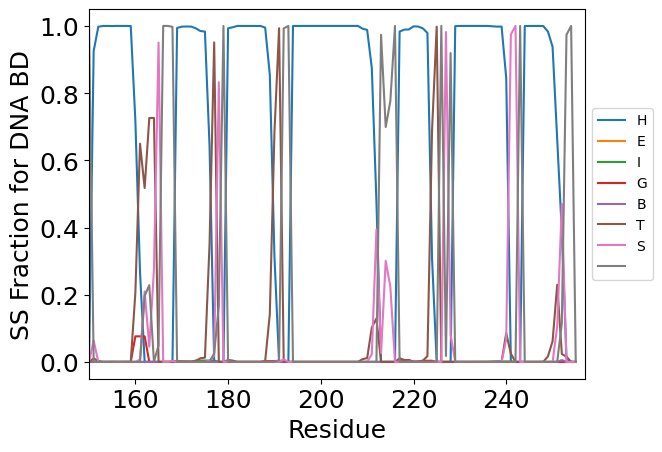

In [42]:
#Zoom in on the DNA binding domain
for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Residue', size=18)
plt.ylabel('SS Fraction for DNA BD', size=18)
plt.tick_params(labelsize=18)
plt.xlim(150,257)

In [43]:
#Here is a calculator to help my brain
def correct_residue_numbers(actual_residue_nums):
    # Adjust each residue number in the list by subtracting 22
    adjusted_residue_nums = [num - 22 for num in actual_residue_nums]
    
    # Check if any adjusted residue number is invalid
    for num in adjusted_residue_nums:
        if num < 0:
            raise ValueError(f"The adjusted residue number {num + 22} is out of bounds.")
    
    return adjusted_residue_nums
#Here I am inputing residues that are either known to be important for inhibition or are hypothesized to be. 
actual_residue_nums = [24, 26, 29, 32, 87, 149, 188, 222, 223]
residue_indices = correct_residue_numbers(actual_residue_nums)
print(f"The indices for the actual residue numbers {actual_residue_nums} are {residue_indices}.")

The indices for the actual residue numbers [24, 26, 29, 32, 87, 149, 188, 222, 223] are [2, 4, 7, 10, 65, 127, 166, 200, 201].


In [16]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [17]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [18]:
def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return

In [47]:
res_interest_idx= [2, 4, 7, 10, 65, 127, 166, 200, 201, 254]
def print_residue_info(trj, indices):
    for idx in indices:
        residue = trj.topology.residue(idx)
        print(f"Residue {residue.index + 1}: {residue.name} (resSeq {residue.resSeq})")

print_residue_info(trj, res_interest_idx)

Residue 3: LEU (resSeq 3)
Residue 5: LEU (resSeq 5)
Residue 8: ILE (resSeq 8)
Residue 11: TYR (resSeq 11)
Residue 66: HIS (resSeq 66)
Residue 128: TYR (resSeq 128)
Residue 167: TRP (resSeq 167)
Residue 201: ILE (resSeq 201)
Residue 202: ARG (resSeq 202)
Residue 255: LIG (resSeq 255)


Residue 3


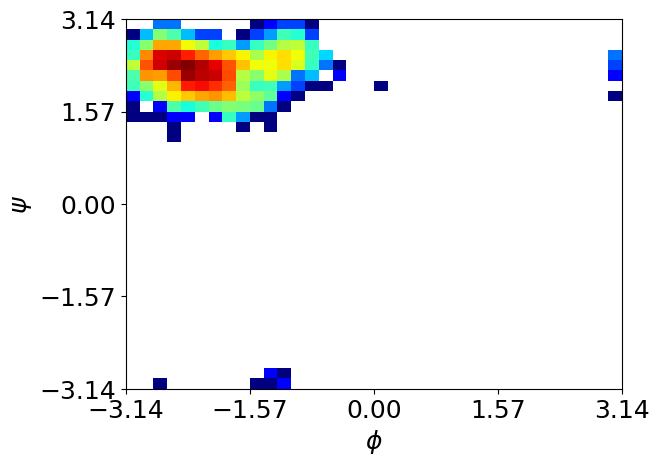

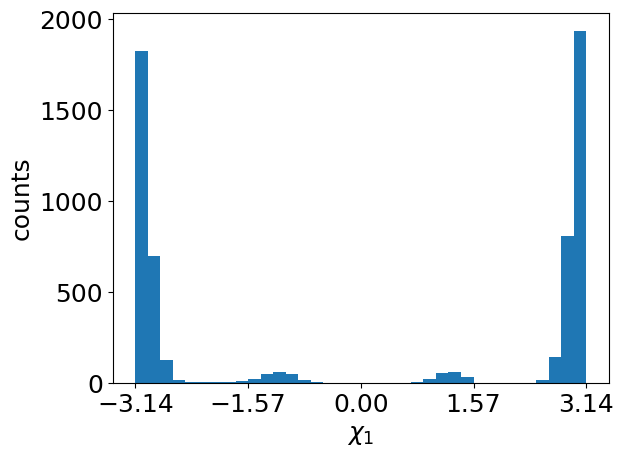

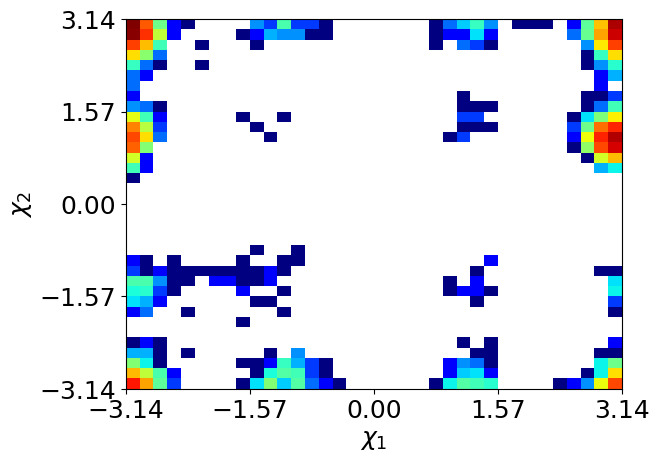

Residue 5


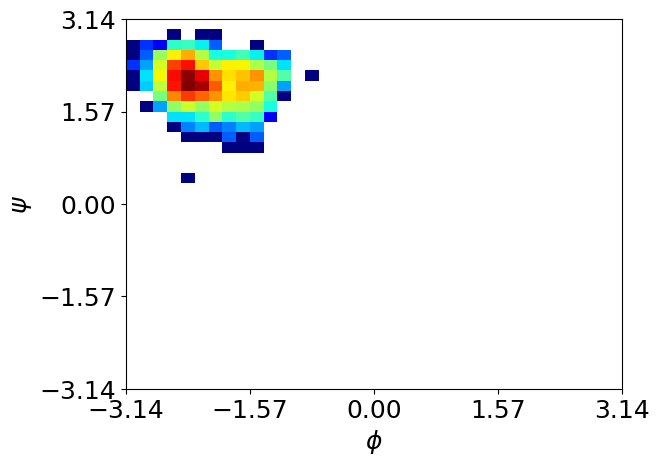

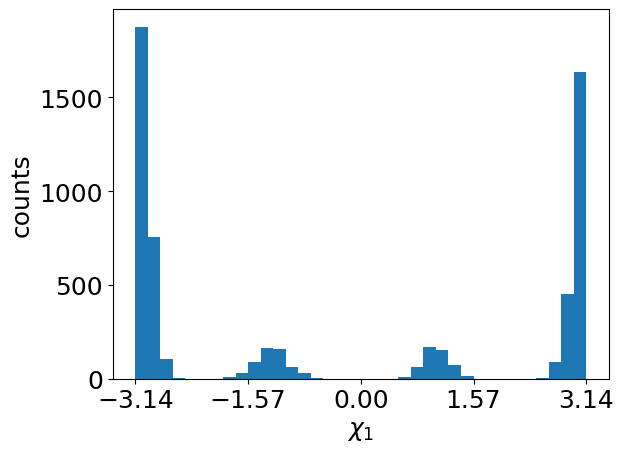

Residue 8


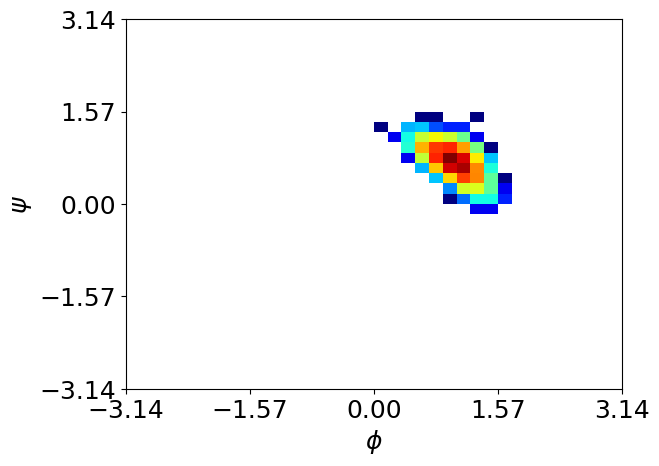

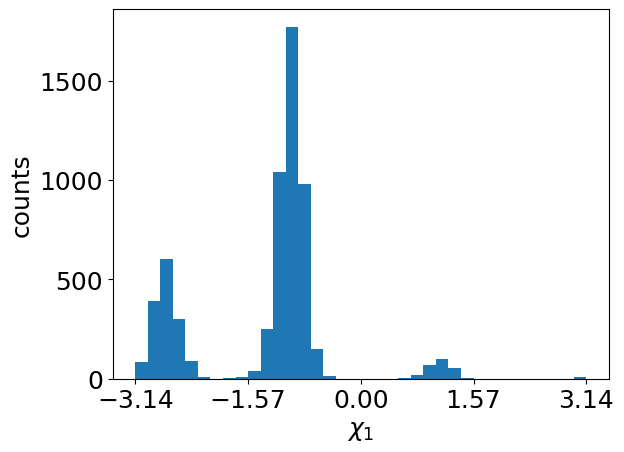

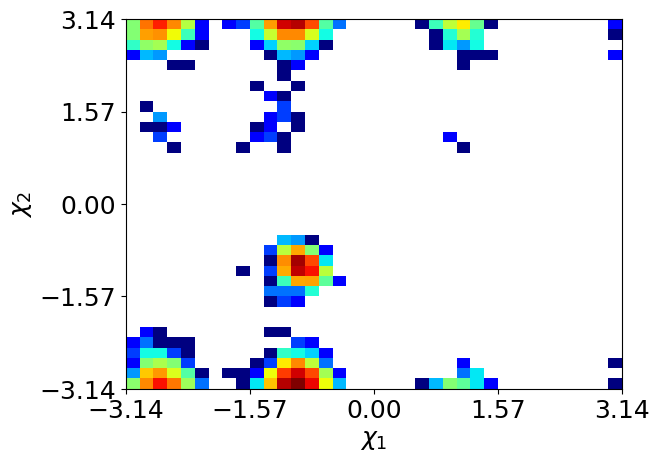

Residue 11


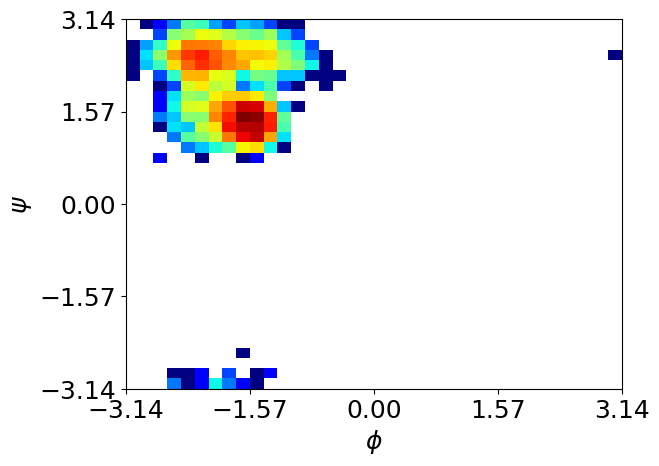

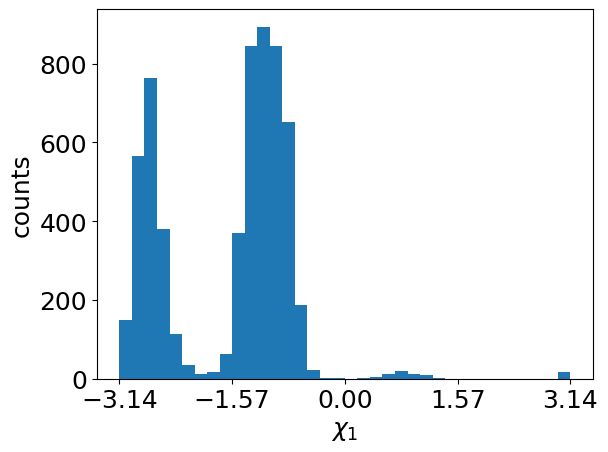

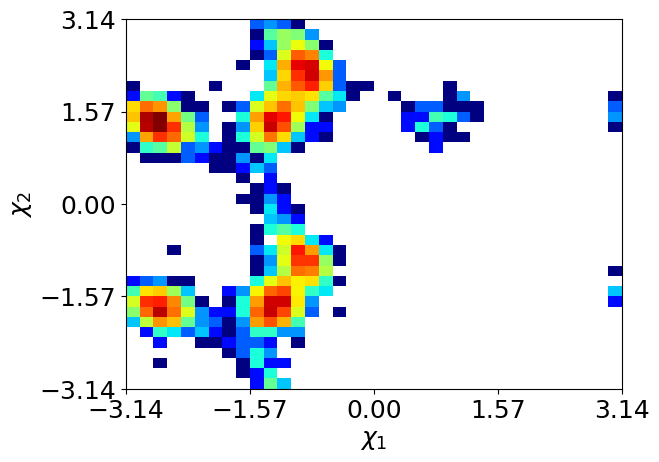

Residue 66


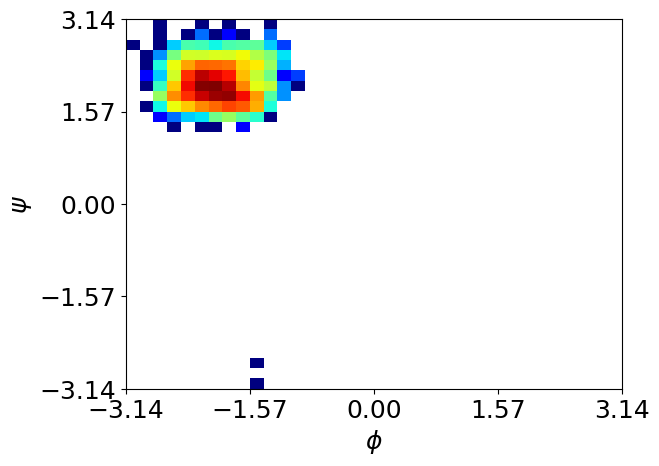

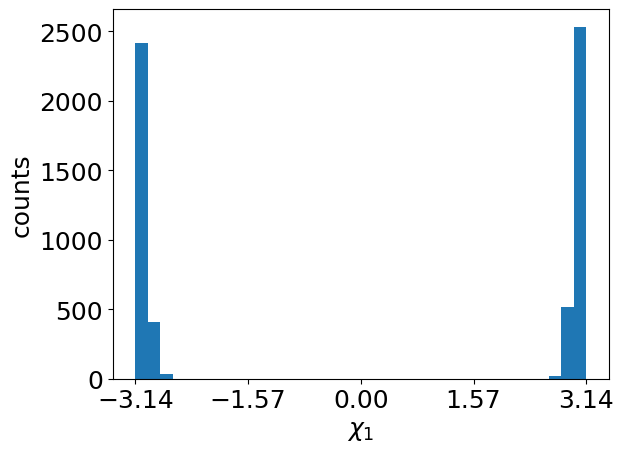

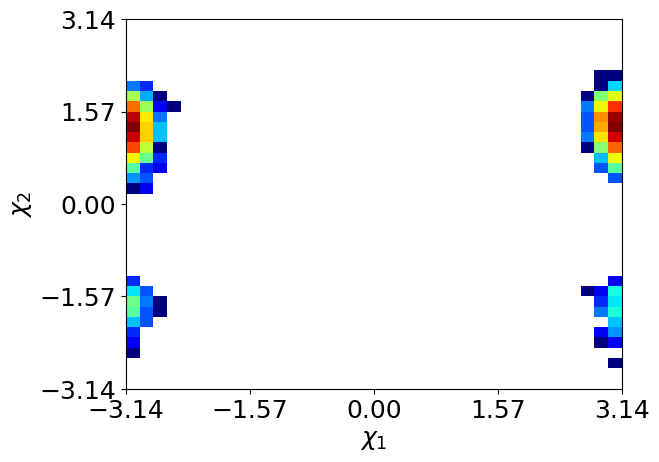

Residue 128


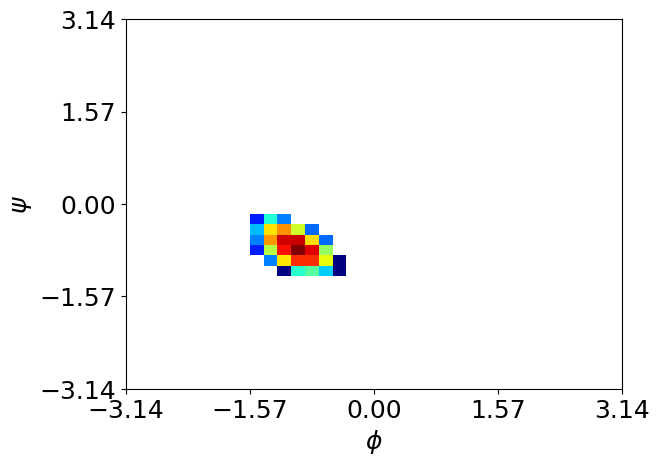

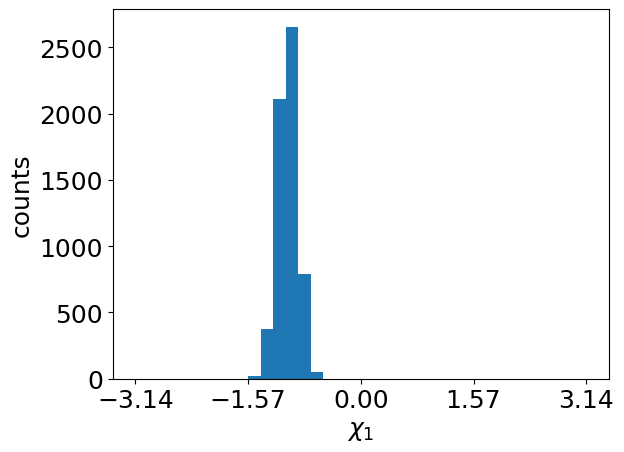

Residue 167


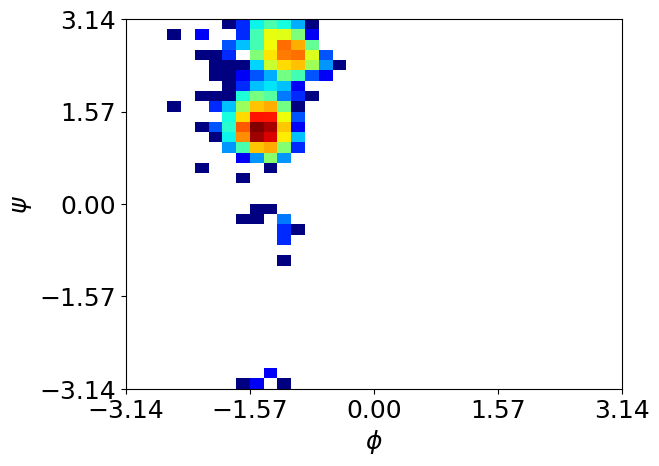

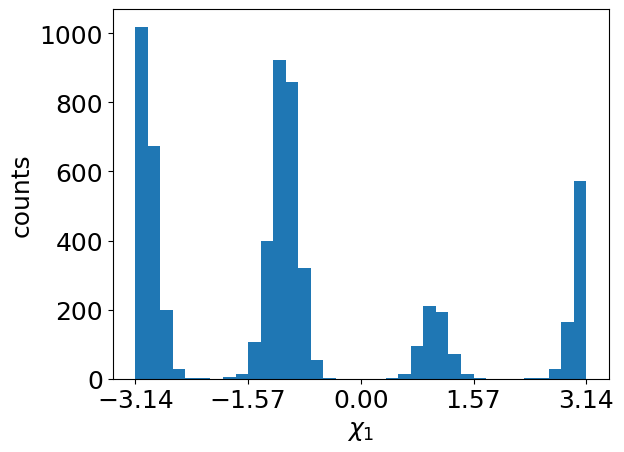

Residue 201


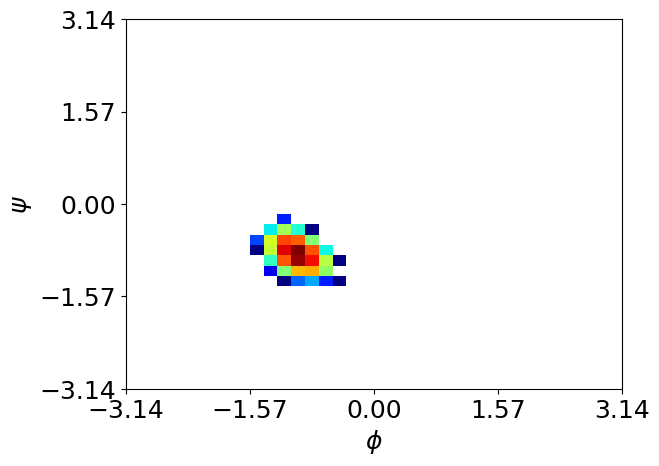

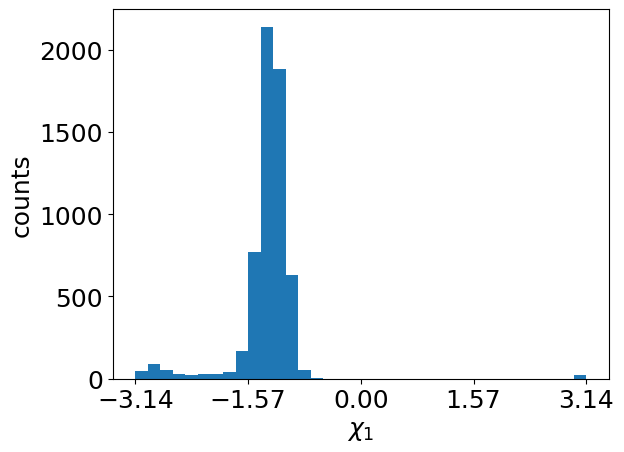

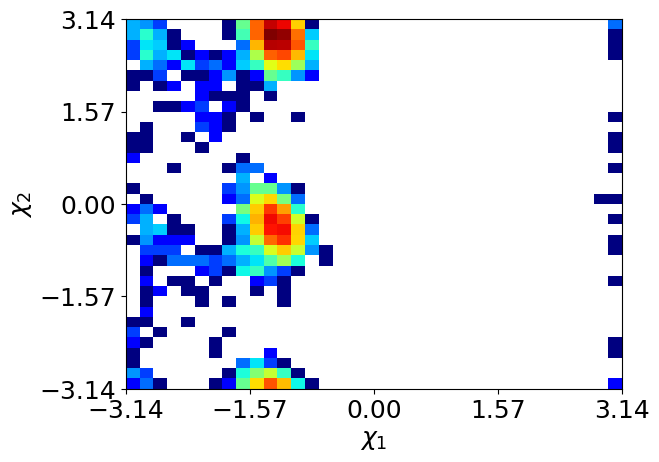

Residue 202


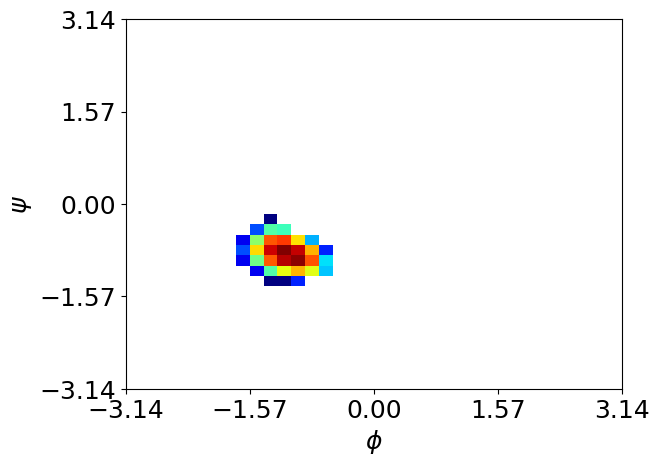

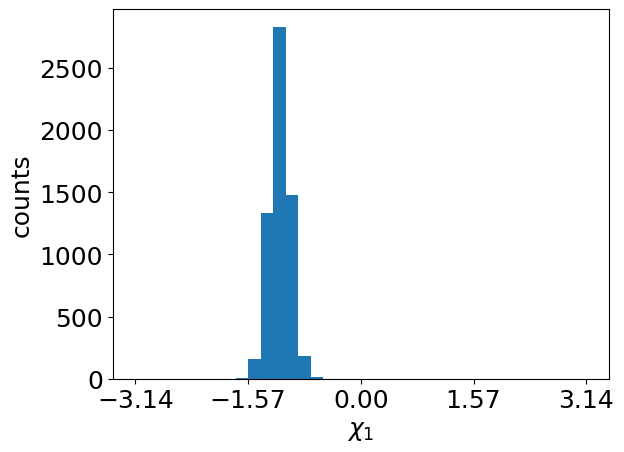

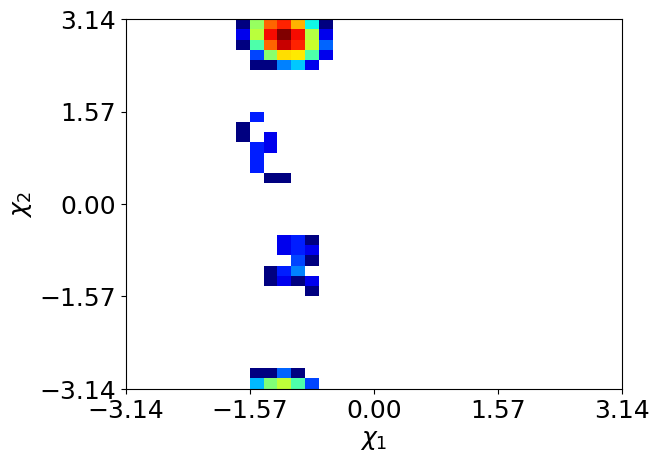

<Figure size 640x480 with 0 Axes>

In [48]:
res_interest= [2, 4, 7, 10, 65, 127, 166, 200, 201]
for i in res_interest:
    print("Residue", i+1)
    plot_phipsi(i)
    plt.clf()
    plot_chi(i)
    plt.clf()
#11 is very different compared to apo

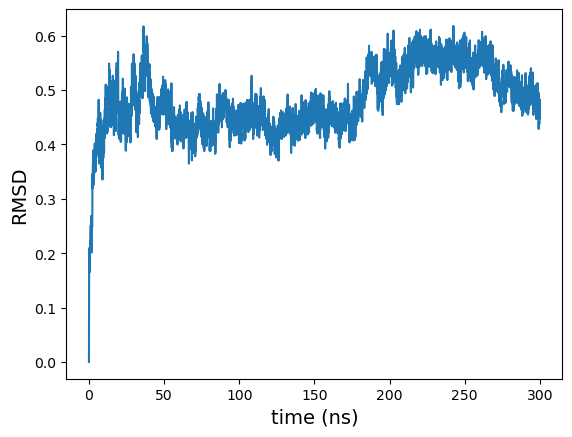

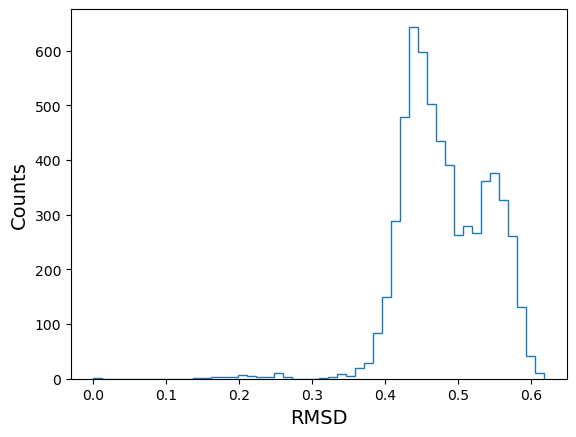

In [10]:
#Calculate RMSD
time=np.linspace(0,300,trj.n_frames)
rmsd = md.rmsd(trj, trj, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time (ns)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()
# Combine time and rmsd into a single array for saving
data = np.column_stack((time, rmsd))

# Save the data to a .dat file
outfile = os.path.join(outdir, 'RegA_MYS_noCorN_rmsd_data.dat')
np.savetxt(outfile, data, header='time(ns) rmsd', comments='')

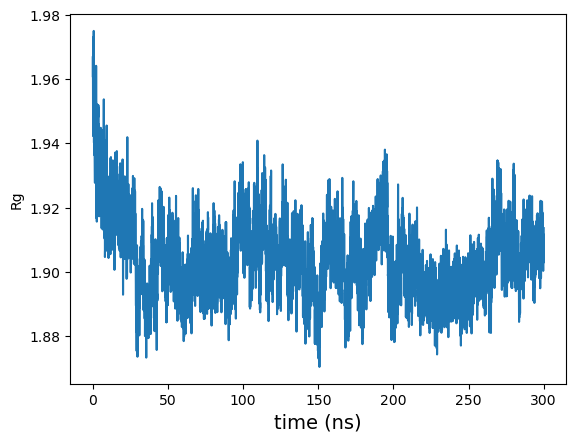

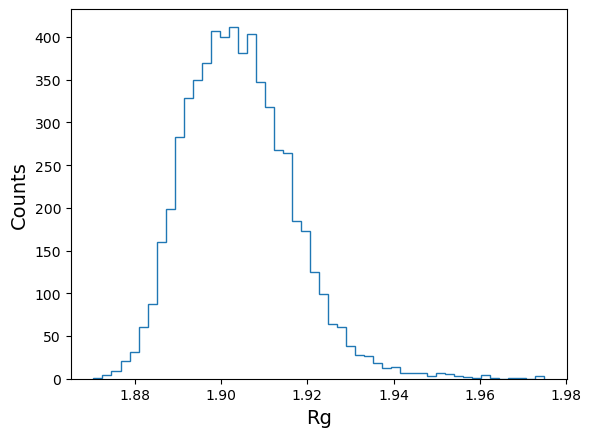

Time series data saved to ./outdir_MYS\RegA_MYS_noCorN_time_series_Rg.dat


In [11]:
#Calculate the radius of gyration and make a histogram
rg=md.compute_rg(trj, masses=None) 
plt.plot(time,rg)
plt.ylabel('Rg');
plt.xlabel('time (ns)',size=14)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('Rg',size=14)
plt.show()
# Combine time and rg into a single array for saving
data = np.column_stack((time, rg))

# Save the data to a .dat file in the output directory
outfile_time_series = os.path.join(outdir, 'RegA_MYS_noCorN_time_series_Rg.dat')
np.savetxt(outfile_time_series, data, header='time(ns) Rg', comments='')
print(f"Time series data saved to {outfile_time_series}")

In [7]:
#Identify subtantially populated hydrogen bonds
hbonds = md.baker_hubbard(trj, periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))
#donor on left, acceptor on the right, looks at angles to see if acceptable H bond is available there

ASN1-N -- VAL55-O
ASN1-ND2 -- LEU249-O
ASN1-ND2 -- LYS250-O
LEU3-N -- LEU53-O
LEU5-N -- VAL51-O
LYS7-N -- ASP50-OD1
LYS7-N -- ASP50-OD2
ILE8-N -- MET49-O
ARG9-NE -- ASN46-OD1
ARG9-NE -- ASP200-OD1
ARG9-NE -- ASP200-OD2
ARG9-NH1 -- GLU190-O
ARG9-NH2 -- ASN46-OD1
ARG9-NH2 -- ASP200-OD1
ARG9-NH2 -- ASP200-OD2
ARG9-NH2 -- GLU190-O
PHE10-N -- THR47-O
TYR11-N -- ARG9-O
ASN12-N -- PHE10-O
ASN12-N -- ASN12-OD1
ASN12-ND2 -- HIS66-ND1
ASN12-ND2 -- CYS13-O
ALA14-N -- VAL43-O
ILE15-N -- TYR65-O
ILE16-N -- CYS41-O
HIS17-N -- GLU63-O
HIS17-NE2 -- THR106-OG1
LEU18-N -- SER39-O
ARG19-N -- PRO61-O
ARG19-NH1 -- GLU38-OE1
ARG19-NH1 -- GLU38-OE2
ARG19-NH1 -- GLU103-OE1
ARG19-NH1 -- GLU103-OE2
ARG19-NH2 -- GLU103-OE1
ARG19-NH2 -- GLU103-OE2
ASP20-N -- PRO61-O
GLN22-N -- LYS54-O
GLN22-NE2 -- ASN34-OD1
LEU23-N -- ILE35-O
LEU24-N -- ALA52-O
ILE25-N -- LEU33-O
ARG26-N -- ASP50-O
THR27-N -- GLN31-O
LYS28-N -- VAL48-O
ASP29-N -- ASP29-OD1
ASP29-N -- ASP29-OD2
GLY30-N -- THR27-O
GLN31-N -- THR27-OG1
GLN31-NE2 -- 

In [ ]:
hbonds_protein = md.baker_hubbard(trj.atom_slice(trj.topology.select("protein")), periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
for hbond in hbonds_protein:
    print(label(hbond))

In [52]:
for hbond in hbonds:
 donor = top.atom(hbond[0])
 acc = top.atom(hbond[2])
 print(hbond,donor,acc)

[  0   2 919] ASN1-N VAL55-O
[  11   13 4100] ASN1-ND2 LEU249-O
[  11   13 4122] ASN1-ND2 LYS250-O
[ 33  34 881] LEU3-N LEU53-O
[ 68  69 852] LEU5-N VAL51-O
[109 110 833] LYS7-N ASP50-OD1
[109 110 834] LYS7-N ASP50-OD2
[131 132 824] ILE8-N MET49-O
[163 164 772] ARG9-NE ASN46-OD1
[ 163  164 3295] ARG9-NE ASP200-OD1
[ 163  164 3296] ARG9-NE ASP200-OD2
[ 166  168 3149] ARG9-NH1 GLU190-O
[169 170 772] ARG9-NH2 ASN46-OD1
[ 169  170 3295] ARG9-NH2 ASP200-OD1
[ 169  170 3296] ARG9-NH2 ASP200-OD2
[ 169  171 3149] ARG9-NH2 GLU190-O
[174 175 791] PHE10-N THR47-O
[194 195 173] TYR11-N ARG9-O
[215 216 193] ASN12-N PHE10-O
[215 216 223] ASN12-N ASN12-OD1
[ 224  225 1075] ASN12-ND2 HIS66-ND1
[224 226 239] ASN12-ND2 CYS13-O
[240 241 726] ALA14-N VAL43-O
[ 250  251 1066] ILE15-N TYR65-O
[269 270 689] ILE16-N CYS41-O
[ 288  289 1029] HIS17-N GLU63-O
[ 299  300 1727] HIS17-NE2 THR106-OG1
[305 306 659] LEU18-N SER39-O
[324 325 993] ARG19-N PRO61-O
[340 341 645] ARG19-NH1 GLU38-OE1
[340 341 646] ARG19-NH1

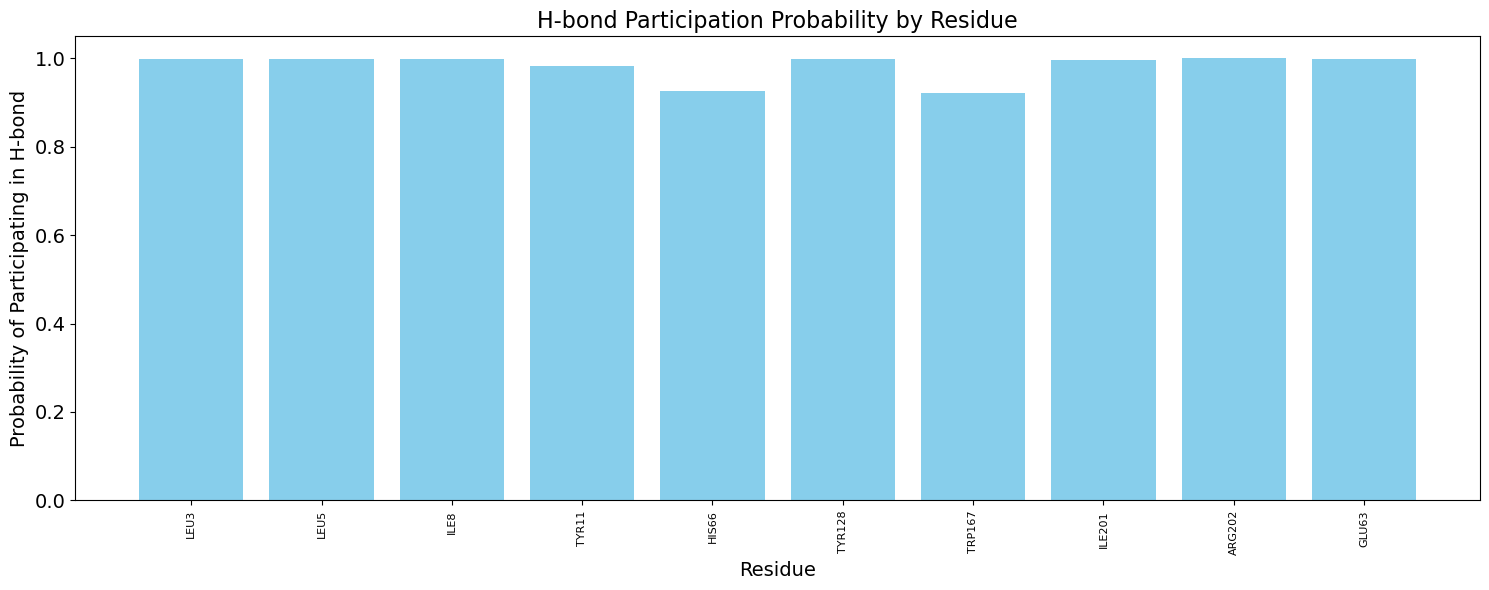

In [53]:
# this is with ligand hbonds
# Define residues of interest
residues_of_interest = [2, 4, 7, 10, 65, 127, 166, 200, 201, 62]

# Initialize a dictionary to track H-bond participation for residues of interest
hbond_participation = {res: np.zeros(trj.n_frames) for res in residues_of_interest}

# Iterate over each frame
for frame in range(trj.n_frames):
    hbonds_frame = md.baker_hubbard(trj[frame], periodic=False)
    for hbond in hbonds_frame:
        donor_residue = trj.topology.atom(hbond[0]).residue.index
        acceptor_residue = trj.topology.atom(hbond[2]).residue.index
        if donor_residue in residues_of_interest:
            hbond_participation[donor_residue][frame] = 1
        if acceptor_residue in residues_of_interest:
            hbond_participation[acceptor_residue][frame] = 1

# Calculate the probability of each residue participating in an H-bond
hbond_probability = {res: np.mean(hbond_participation[res]) for res in hbond_participation}

# Extract residues of interest and their H-bond participation probabilities
residues = residues_of_interest
probabilities = [hbond_probability[res] for res in residues]

# Convert residue indices to residue names and sequence numbers
residue_labels = [f"{trj.topology.residue(res).name}{trj.topology.residue(res).resSeq}" for res in residues]

data = np.column_stack((residues, probabilities))
outfile = os.path.join(outdir, 'RegA_MYS_noCorN_hbond_prob_interesting_res_data.dat')
np.savetxt(outfile, data, header='time(ns) rmsd', comments='')

# Plot the H-bond participation probability
plt.figure(figsize=(15, 6))
plt.bar(residue_labels, probabilities, color='skyblue')
plt.xlabel('Residue', size=14)
plt.ylabel('Probability of Participating in H-bond', size=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(size=14)
plt.title('H-bond Participation Probability by Residue', size=16)
plt.tight_layout()
plt.show()

[ 33  34 881] LEU3-N LEU53-O
[863 864  51] LEU53-N LEU3-O


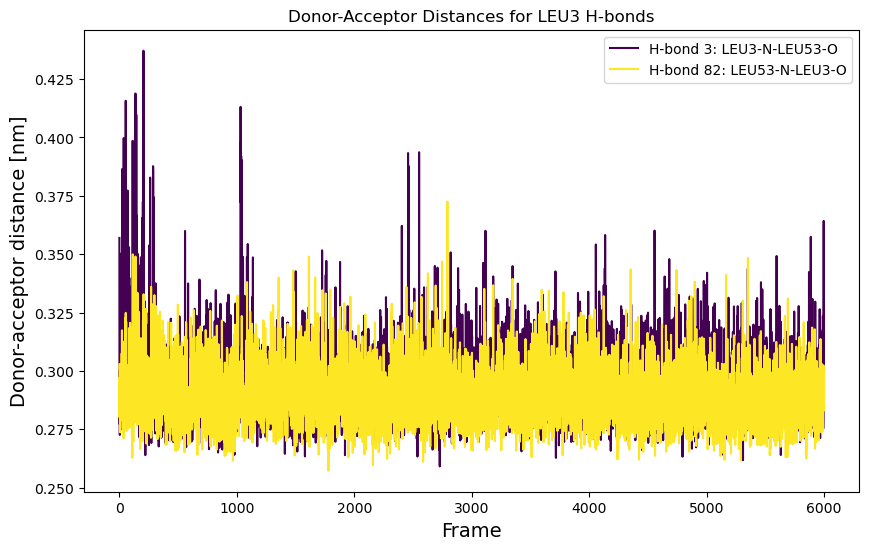

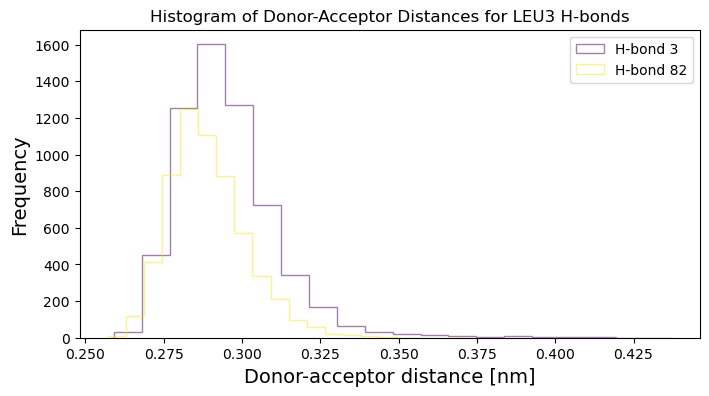

[ 68  69 852] LEU5-N VAL51-O
[837 838  86] VAL51-N LEU5-O


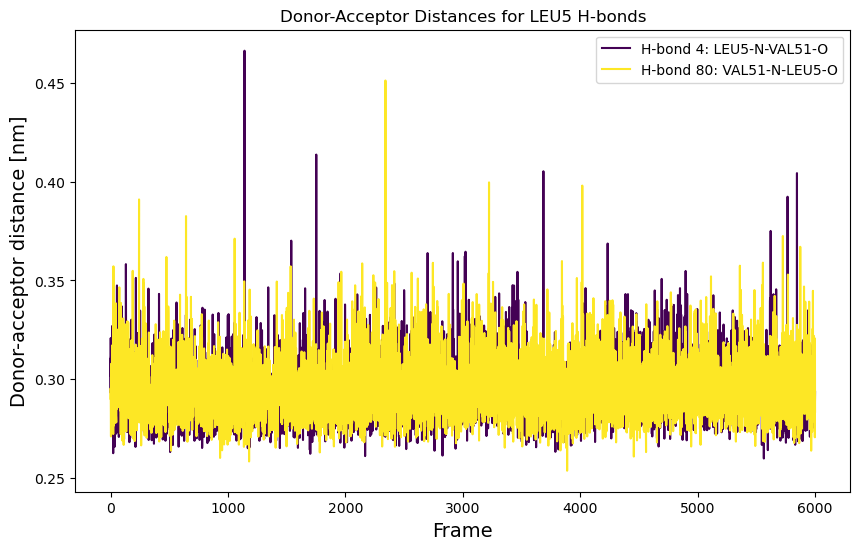

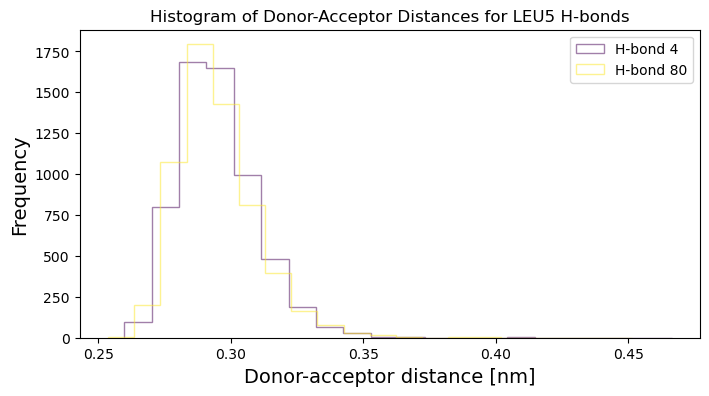

[131 132 824] ILE8-N MET49-O
[808 809 149] MET49-N ILE8-O


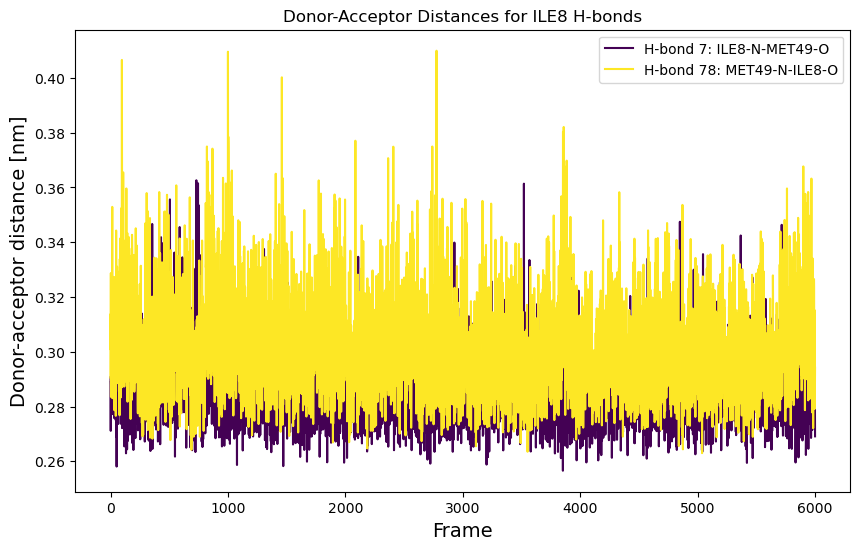

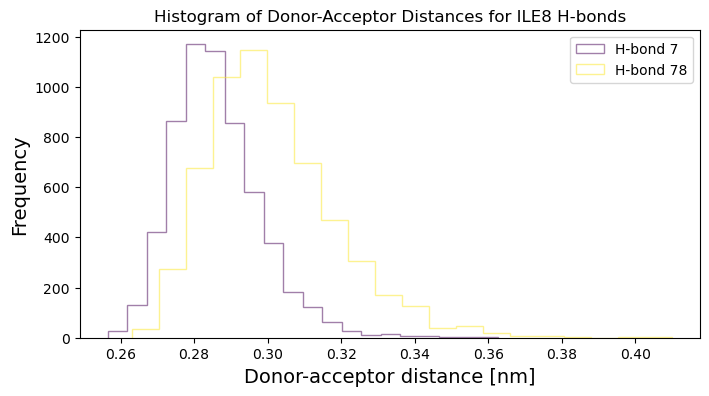

[3299 3300 3251] ILE201-N LEU197-O
[3380 3381 3317] HIS205-N ILE201-O


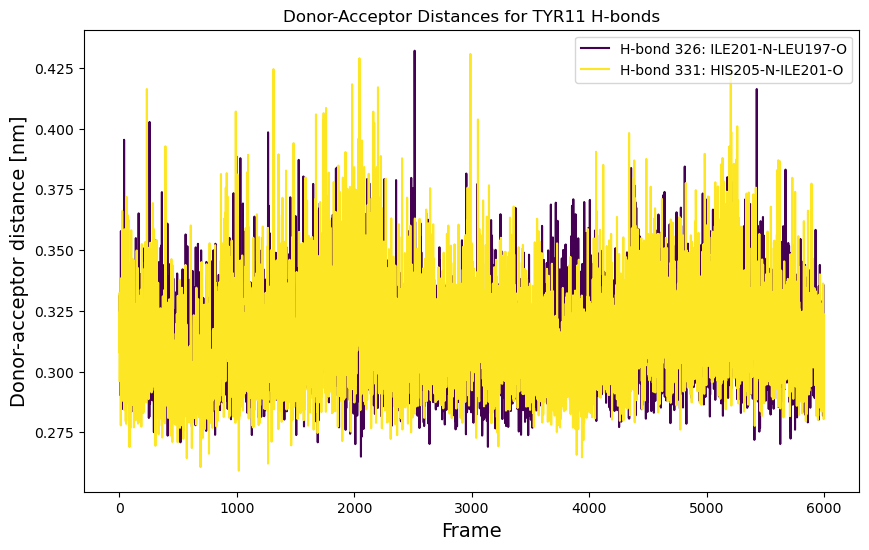

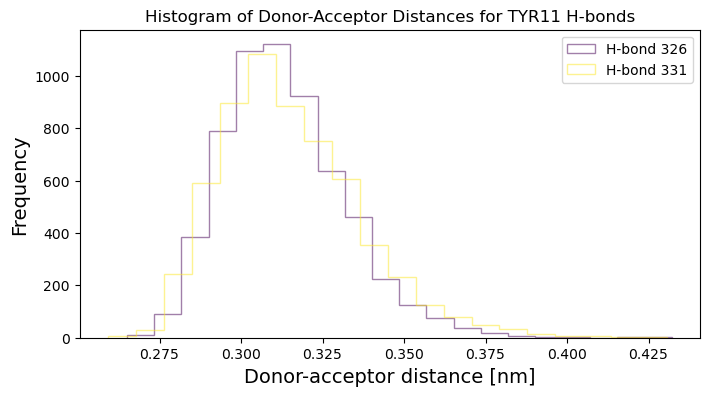

[ 224  225 1075] ASN12-ND2 HIS66-ND1
[1078 1079 1108] HIS66-NE2 ASP68-OD1
[1947 1948 1083] GLN119-NE2 HIS66-O


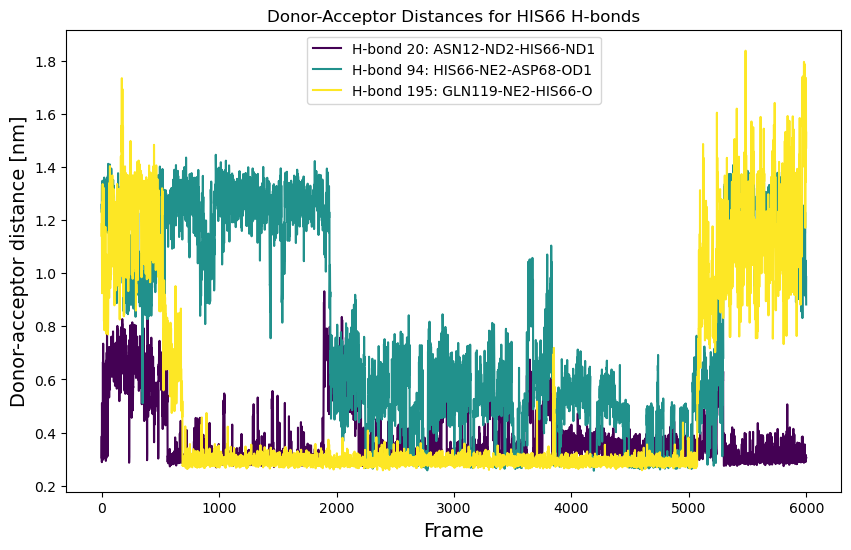

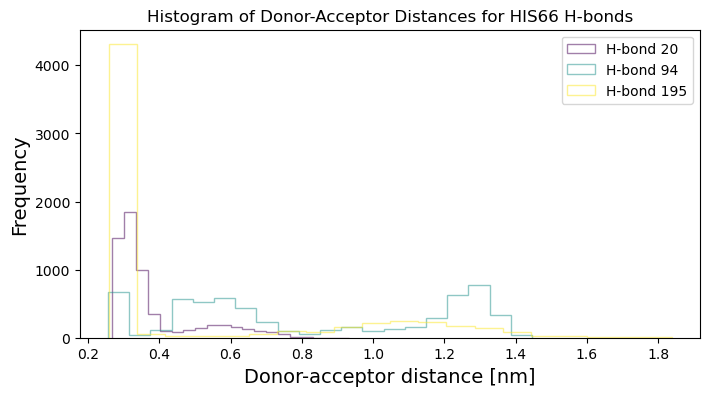

[2104 2105 2048] TYR128-N TYR124-O
[2163 2164 2124] SER131-N TYR128-O
[2117 2118 1713] TYR128-OH ASP105-OD1
[2117 2118 1714] TYR128-OH ASP105-OD2
[2170 2171 2124] SER131-OG TYR128-O


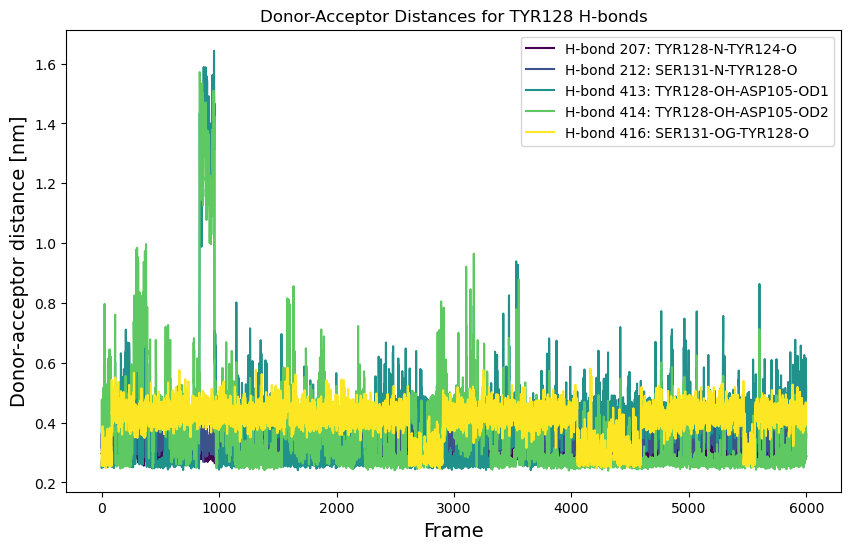

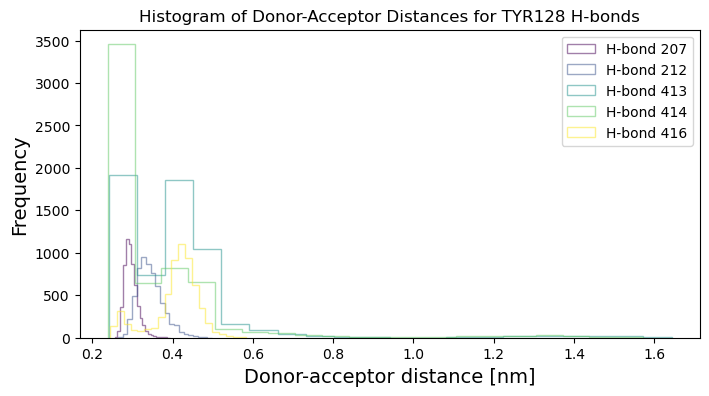

[2729 2730 2717] TRP167-N ARG165-O
[2739 2740 2626] TRP167-NE1 ILE159-O
[2739 2740 2663] TRP167-NE1 ASP162-O


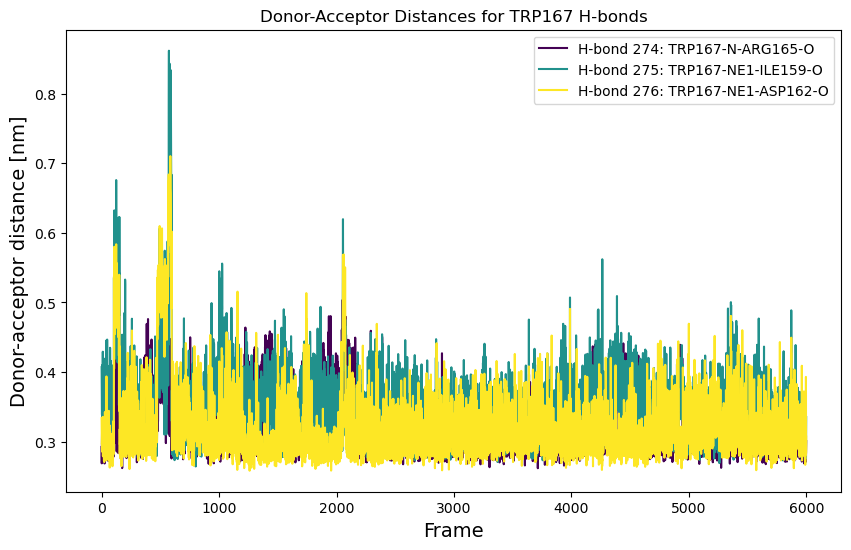

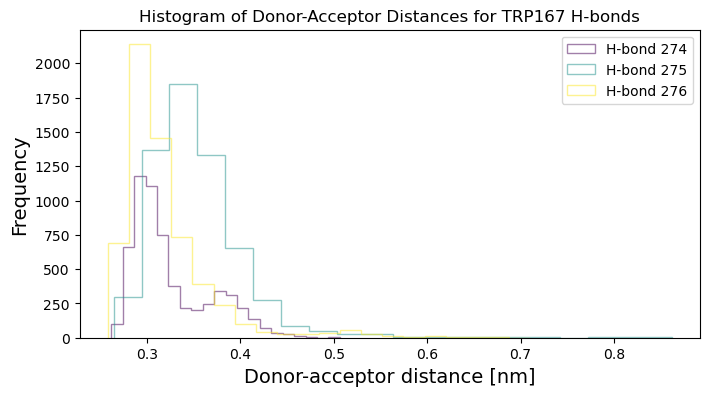

[3299 3300 3251] ILE201-N LEU197-O
[3380 3381 3317] HIS205-N ILE201-O


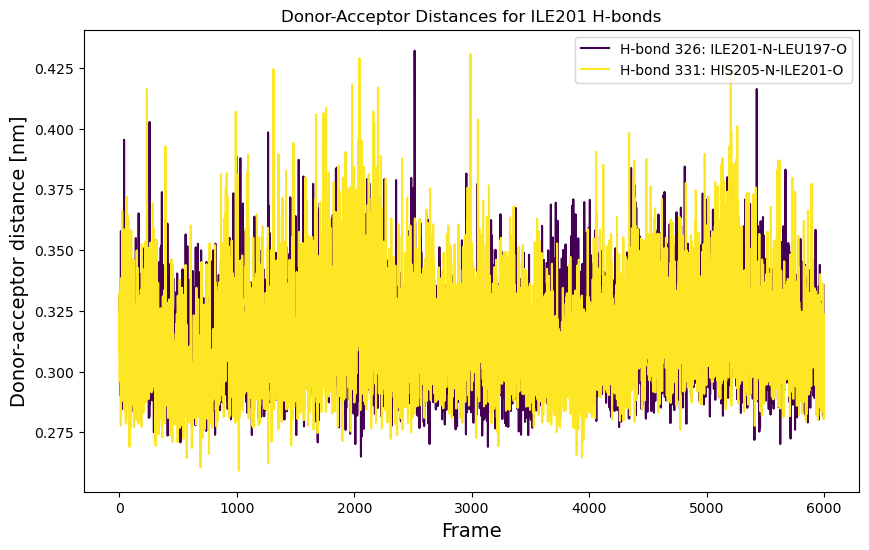

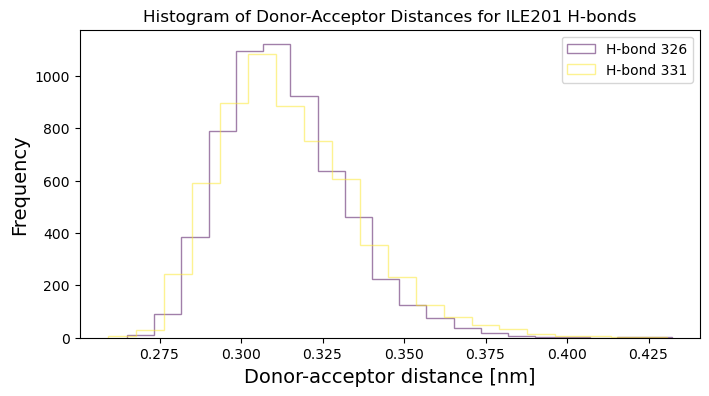

[3318 3319 3267] ARG202-N VAL198-O
[3331 3332 3684] ARG202-NE VAL224-O
[3397 3398 3341] ALA206-N ARG202-O


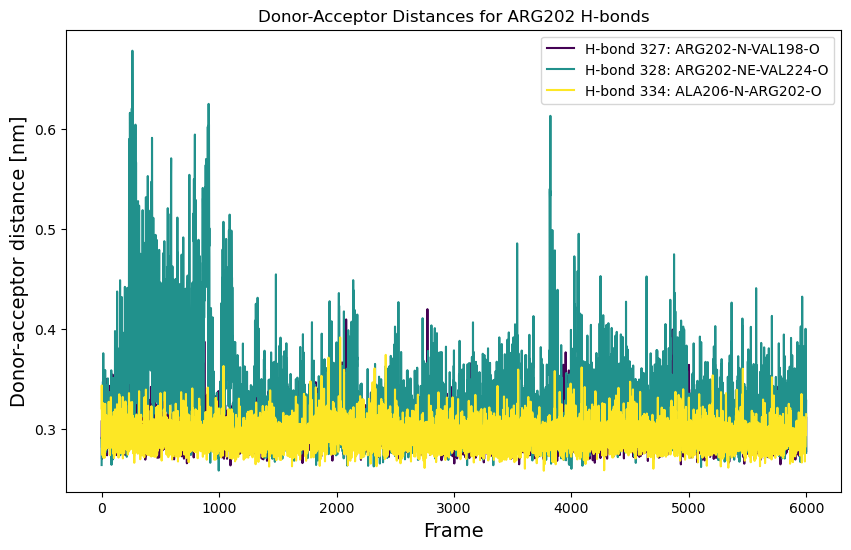

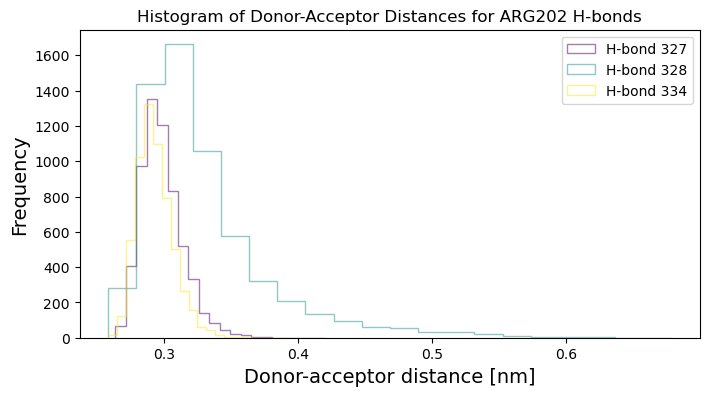

[ 288  289 1029] HIS17-N GLU63-O
[1015 1016  304] GLU63-N HIS17-O
[1030 1031 1026] VAL64-N GLU63-OE1
[1030 1031 1027] VAL64-N GLU63-OE2
[4204 4219 1026] LIG255-O2 GLU63-OE1
[4204 4219 1027] LIG255-O2 GLU63-OE2


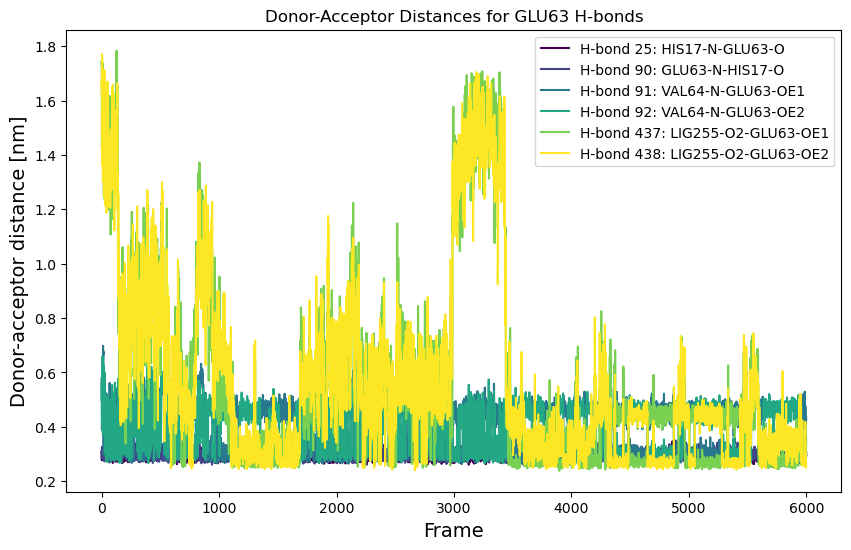

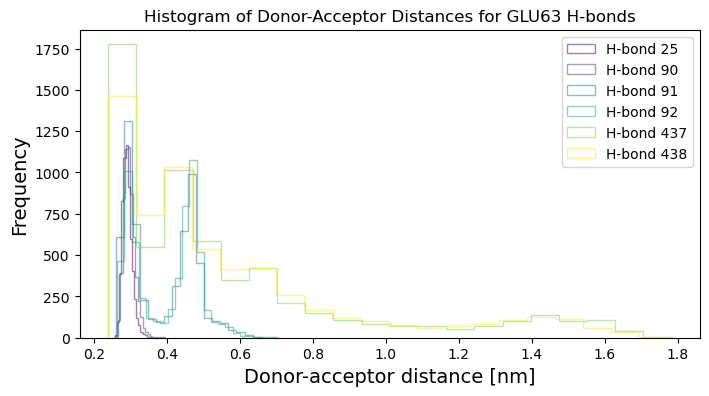

[4204 4219 1026] LIG255-O2 GLU63-OE1
[4204 4219 1027] LIG255-O2 GLU63-OE2


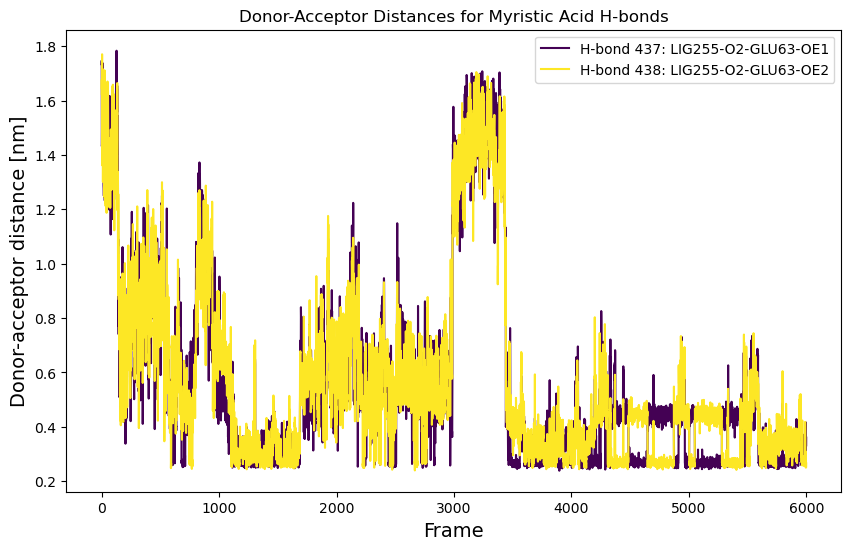

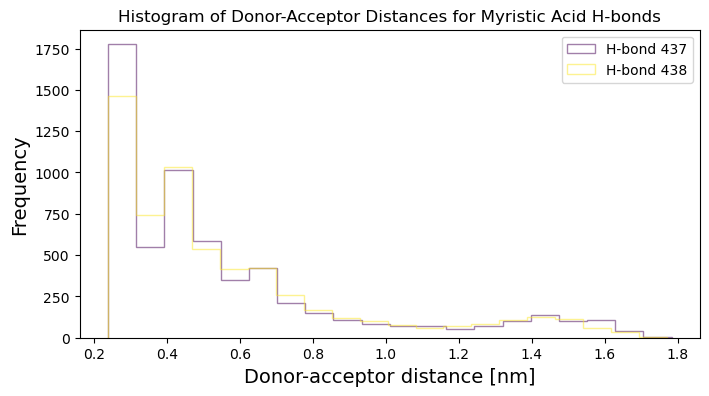

<Figure size 640x480 with 0 Axes>

In [8]:
# H-bonds of interest
def plot_hbonds(hbonds, hbond_indices, trj, top, list_name):
    colors = plt.cm.viridis(np.linspace(0, 1, len(hbond_indices)))
    
    plt.figure(figsize=(10, 6))

    for i, Hbond_index in enumerate(hbond_indices):
        hbond = hbonds[Hbond_index]
        donor = top.atom(hbond[0])
        acc = top.atom(hbond[2])
        print(hbond, donor, acc)

        da_distance = md.compute_distances(trj, [[hbond[0], hbond[2]]], periodic=False)
        
        plt.plot(da_distance, color=colors[i], label=f'H-bond {Hbond_index}: {donor}-{acc}')
        output_file = os.path.join(os.getcwd(), f'{list_name}_da_dist.png')
        plt.savefig(output_file, bbox_inches='tight')

    plt.legend()
    plt.ylabel('Donor-acceptor distance [nm]', size=14)
    plt.xlabel('Frame', size=14)
    plt.title(f'Donor-Acceptor Distances for {list_name}')
    output_file = os.path.join(os.getcwd(), f'{list_name}_distance.png')
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(8, 4))
    
    for i, Hbond_index in enumerate(hbond_indices):
        hbond = hbonds[Hbond_index]
        da_distance = md.compute_distances(trj, [[hbond[0], hbond[2]]], periodic=False)
        
        plt.hist(da_distance, histtype='step', bins=20, color=colors[i], label=f'H-bond {Hbond_index}', alpha=0.5)
        
    plt.legend()
    plt.ylabel('Frequency', size=14)
    plt.xlabel('Donor-acceptor distance [nm]', size=14)
    plt.title(f'Histogram of Donor-Acceptor Distances for {list_name}')
    output_file = os.path.join(os.getcwd(), f'{list_name}_distance.png')
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()
# 3 , 82 --- LEU3
# 4 , 80 --- LEU5
# 7 , 78--- ILE8
# 326 , 331--- TYR11
# 20 , 94 , 195 ---HIS66
# 207 ,212 , 413 , 414 , 416 --- TYR128
# 274 , 275 , 276 --- TRP167
# 326 , 331 --- ILE201
#327 , 328 , 334 ---ARG202
# 25, 90 , 91, 92 , 437 , 438 ---GLU63
# 437 , 438 ---LIG255
LEU3_hbonds = [3 , 82]  
plot_hbonds(hbonds, LEU3_hbonds, trj, top, 'LEU3 H-bonds')  
LEU5_hbonds = [4 , 80]  
plot_hbonds(hbonds, LEU5_hbonds, trj, top, 'LEU5 H-bonds')  
ILE8_hbonds = [7 , 78]  
plot_hbonds(hbonds, ILE8_hbonds, trj, top, 'ILE8 H-bonds') 
TYR11_hbonds = [326 , 331]  
plot_hbonds(hbonds, TYR11_hbonds, trj, top, 'TYR11 H-bonds') 
HIS66_hbonds = [20 , 94 , 195]  
plot_hbonds(hbonds, HIS66_hbonds, trj, top, 'HIS66 H-bonds')
TYR128_hbonds = [207 ,212 , 413 , 414 , 416]  
plot_hbonds(hbonds, TYR128_hbonds, trj, top, 'TYR128 H-bonds')
TRP167_hbonds = [274 , 275 , 276]  
plot_hbonds(hbonds, TRP167_hbonds, trj, top, 'TRP167 H-bonds')
ILE201_hbonds = [326 , 331]  
plot_hbonds(hbonds, ILE201_hbonds, trj, top, 'ILE201 H-bonds')
ARG202_hbonds = [327 , 328 , 334]  
plot_hbonds(hbonds, ARG202_hbonds, trj, top, 'ARG202 H-bonds')
GLU63_hbonds = [25, 90 , 91, 92 , 437 , 438]  
plot_hbonds(hbonds, GLU63_hbonds, trj, top, 'GLU63 H-bonds')
LIG255_hbonds = [437 , 438]  
plot_hbonds(hbonds, LIG255_hbonds, trj, top, 'Myristic Acid H-bonds')
output_file = os.path.join(os.getcwd(), 'H_bond_LIG_MYS.png')
plt.savefig(output_file, bbox_inches='tight')

In [26]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3)) #this is done because this has lots of dimensions
print(reduced_cartesian.shape) #look at as a function of time, and project onto first 2 components
# makes co-variance matrix, looking at how much the positions of atoms are coorelated across the residues
# look into linear algebra eigen values and vectors....

(6000, 2)


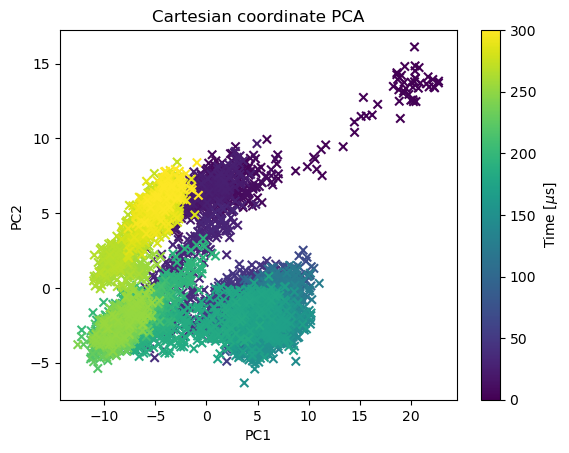

In [27]:
#We Can plot eaceh frame as a function of the values of each PC(principal component): PC1 and PC2
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA')
cbar = plt.colorbar()
cbar.set_label('Time [$\mu$s]')
#when you reduce dimensionality for PCA, you want to project properties back onto there to make sure that you have captured relevant information

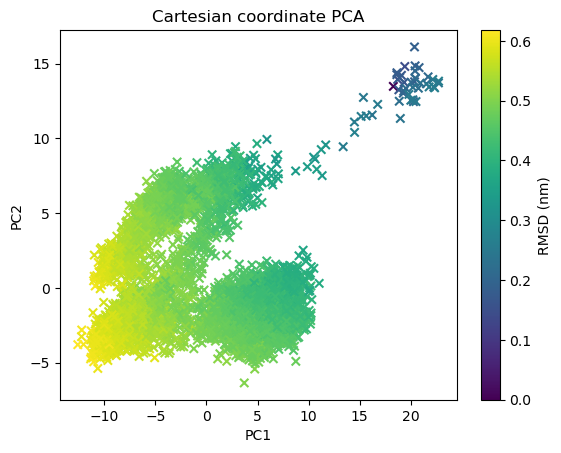

In [28]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

In [66]:
# Contact Map
contact_maps = []
contact_distances = []
for i in range(1, 76):
    contact_map = []
    contact_distance = []
    for j in range(1, 76):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


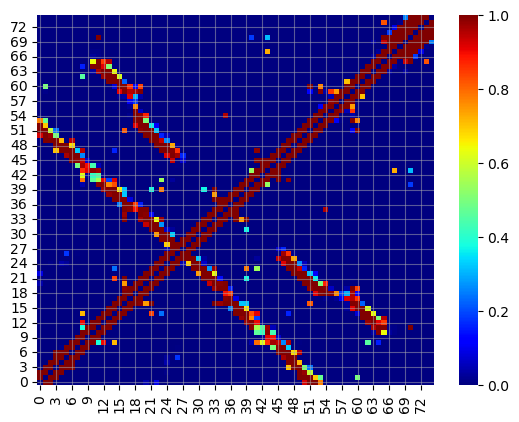

In [67]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)

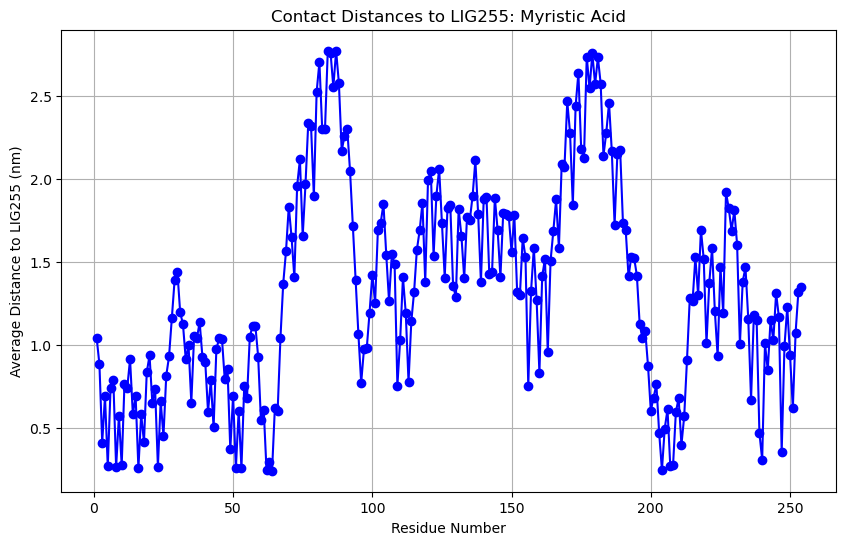

In [65]:
# Plot contact distances from ligand to protein residues
ligand_residue = trj.topology.select('resname LIG and resSeq 255')
# Get the number of residues in the protein (excluding the ligand)
protein_residues = [res for res in trj.topology.residues if res.resSeq != 255]

contact_distances = []

for res in protein_residues:
    residue_atoms = [atom.index for atom in res.atoms]
    distances = md.compute_distances(trj, np.array([[residue_atom, ligand_atom] for residue_atom in residue_atoms for ligand_atom in ligand_residue]))
    min_distances = np.min(distances, axis=1)
    contact_distances.append(np.mean(min_distances))

# Generate residue numbers for the x-axis
residue_numbers = [res.resSeq for res in protein_residues]
#save to .dat file
outfile = os.path.join(outdir, 'RegA_MYS_contact_distances.dat')
with open(outfile, 'w') as f:
    f.write('# Residue_Number Average_Distance_to_LIG255(nm)\n')
    for res_num, distance in zip(residue_numbers, contact_distances):
        f.write(f'{res_num} {distance}\n')
# Plot the distances
plt.figure(figsize=(10, 6))
plt.plot(residue_numbers, contact_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Residue Number')
plt.ylabel('Average Distance to LIG255 (nm)')
plt.title('Contact Distances to LIG255: Myristic Acid')
plt.grid(True)
plt.show()

In [68]:
import pyblock
from itertools import chain
def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(
                len(data), reblock_data)[0]
            if type(opt) != int: 
                opt = 10
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf

Fraction Bound: 1.0


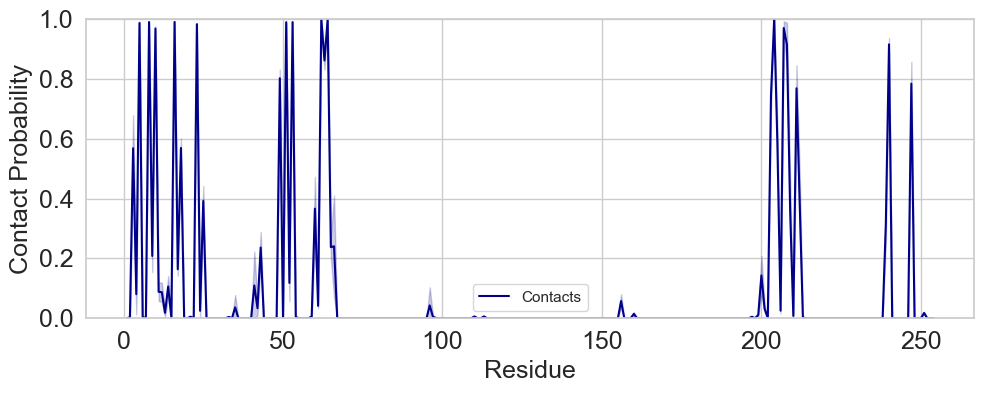

[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.00000000e+00 3.16666667e-03 1.34202997e-03]
 [3.00000000e+00 5.68166667e-01 1.10294250e-01]
 [4.00000000e+00 8.05000000e-02 6.84465125e-02]
 [5.00000000e+00 9.86666667e-01 4.37023635e-03]
 [6.00000000e+00 4.16666667e-03 2.63463295e-03]
 [7.00000000e+00 1.66666667e-04 1.67112299e-04]
 [8.00000000e+00 9.89833333e-01 3.17433102e-03]
 [9.00000000e+00 2.08166667e-01 5.37416123e-02]
 [1.00000000e+01 9.68333333e-01 7.25950075e-03]
 [1.10000000e+01 8.83333333e-02 3.11553278e-02]
 [1.20000000e+01 8.71666667e-02 3.16320349e-02]
 [1.30000000e+01 1.83333333e-02 1.39878265e-02]
 [1.40000000e+01 1.06000000e-01 3.53954073e-02]
 [1.50000000e+01 3.33333333e-04 2.35696322e-04]
 [1.60000000e+01 9.90000000e-01 2.84878679e-03]
 [1.70000000e+01 1.63833333e-01 2.16698428e-02]
 [1.80000000e+01 5.69166667e-01 3.15830325e-02]
 [1.90000000e+01 0.00000000e+00 0.00000000e+00]
 [2.00000000e+01 0.00000000e+00 0.00000000e+00]
 [2.10000000e+01 5.33333333e-03 1.142908

<Figure size 640x480 with 0 Axes>

In [70]:
contact_pairs = np.zeros((254, 2))
ligand_residue_index = 254

for i in range(0, 254):
    contact_pairs[i] = [i, ligand_residue_index]
contact = md.compute_contacts(trj, contact_pairs, scheme='closest-heavy')
contacts = np.asarray(contact[0]).astype(float)
cutoff = 0.6
contact_matrix = np.where(contacts < cutoff, 1, 0)
contact_prob = np.sum(contact_matrix, axis=0)/trj.n_frames
np.savetxt(outdir+'contacts.traj.dat', contact_matrix, '%i')


contact_rows = np.sum(contact_matrix, axis=1)
contact_frames = np.where(contact_rows > 0)[0]
nocontact_frames = np.where(contact_rows == 0)[0]
contact_fraction = np.sum(np.where(contact_rows > 0, 1, 0))/len(contact_rows)
print("Fraction Bound:", contact_fraction)

# Total Contacts with errors
contact_ave, contact_pyb_be = get_blockerrors_pyblock(contact_matrix, 1.0)
contact_ave, contact_pyb_be_max = get_blockerrors_pyblock(contact_matrix, 1.0)

contact_be = np.column_stack((range(1,ligand_residue_index+1), contact_ave, contact_pyb_be))
contact_be_max = np.column_stack((range(1,ligand_residue_index+1), contact_ave, contact_pyb_be_max))

np.savetxt('%s/RegA_MYS_contact.be.pyblock.dat' % outdir, contact_be, '%.4f')
np.savetxt('%s/RegA_MYS_contact.be.pyblock.max.dat' % outdir, contact_be_max, '%.4f')
sns.set(style='whitegrid')

Contact = contact_be
plt.figure(figsize=(10, 4))
sns.lineplot(x=Contact[:, 0], y=Contact[:, 1],
             color='darkblue', label='Contacts')
plt.fill_between(Contact[:, 0], Contact[:, 1]+Contact[:, 2],
                 Contact[:, 1]-Contact[:, 2], color='darkblue', alpha=0.2)

plt.xlabel('Residue', size=18)
plt.ylabel('Contact Probability', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig(outdir+'RegA_MYS_ContactFraction.byResidue.ClosestHeavy.png')
plt.ylim(0, 1)
plt.show()
plt.clf()
print(Contact)

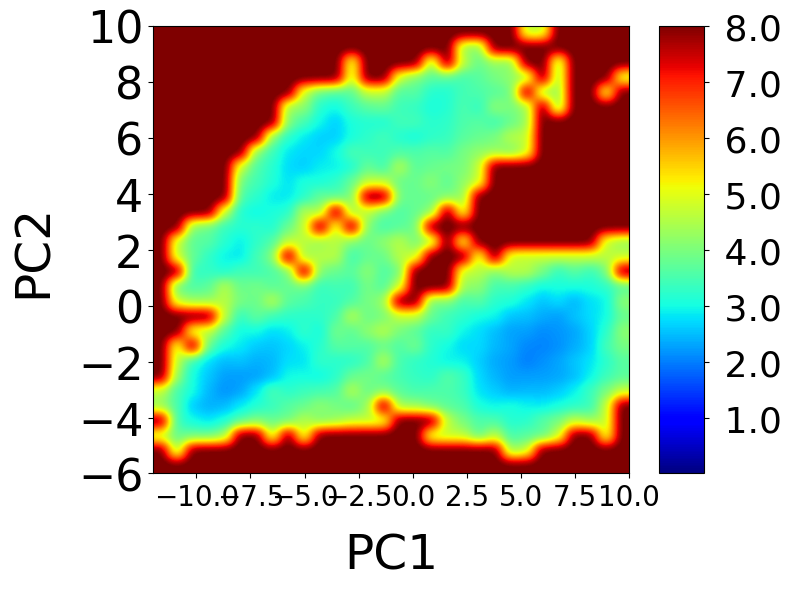

In [29]:
###Make a Pretty Free Energy Plot of PC1 vs. PC2

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -6, 10, -12, 10)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-12,10)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='20')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

RegA_MYS appears to have 3 main states shown in the PCA plot above. 

In [30]:
#Final frames in PC states for visualization
PC_state1_indices = np.where((PC2 < 2)& (PC1<2))[0]  
PC_state2_indices = np.where((PC2 <0) & (PC1<-5))[0]  
PC_state3_indices = np.where(PC2 >2)[0] 

PC_state1_selected = PC_state1_indices[::5]
PC_state2_selected = PC_state2_indices[::5]
PC_state3_selected = PC_state3_indices[::5]
print(PC_state1_selected)
print(PC_state2_selected)
print(PC_state3_selected)

[ 572  577  582  589  594  599  604  609  614  620  665  677  682  687
  692  697  702  707  712  717  722  727  732  737  742  747  752  757
  762  767  772  777  782  787  792  797  802  807  813  819  829  846
  924  931  948  953  958  970  975  980  985  990  998 1004 1011 1016
 1021 1054 1097 1464 1504 2277 2287 2301 2674 3556 3561 3572 3577 3585
 3594 3600 3605 3611 3627 3632 3638 3643 3648 3653 3658 3663 3668 3673
 3678 3683 3688 3693 3698 3703 3708 3713 3718 3723 3728 3733 3738 3743
 3748 3753 3758 3763 3768 3773 3778 3783 3788 3793 3798 3803 3808 3813
 3818 3823 3828 3833 3838 3845 3855 3861 3866 3871 3876 3881 3886 3891
 3896 3901 3906 3914 3919 3924 3929 3934 3939 3944 3949 3954 3959 3964
 3969 3974 3979 3984 3989 3994 3999 4004 4009 4014 4019 4024 4029 4034
 4039 4044 4049 4054 4059 4064 4069 4074 4079 4084 4089 4094 4099 4104
 4109 4114 4119 4124 4129 4134 4139 4144 4149 4154 4159 4164 4169 4174
 4179 4184 4189 4194 4199 4204 4209 4214 4219 4224 4229 4234 4239 4244
 4249 

Evaluate residue of interest stability through autocorrelation functions and isolate long autocorrelations.

Residue LEU3 (Index 2)


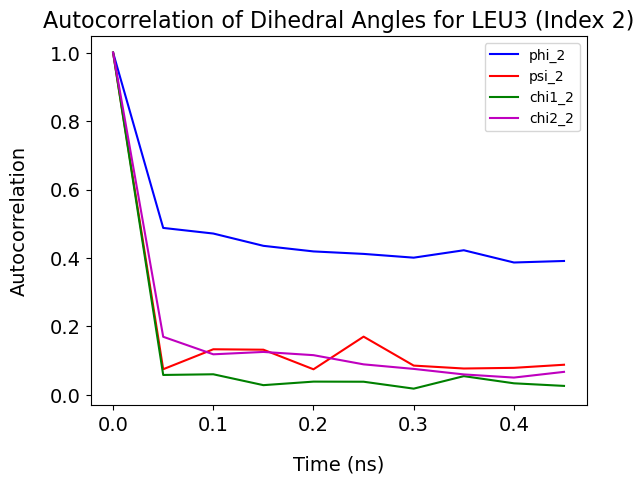

Residue LEU5 (Index 4)


C:\Users\grace\miniconda3\envs\CHEM101\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\grace\miniconda3\envs\CHEM101\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\grace\miniconda3\envs\CHEM101\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\grace\miniconda3\envs\CHEM101\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\grace\miniconda3\envs\CHEM101\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


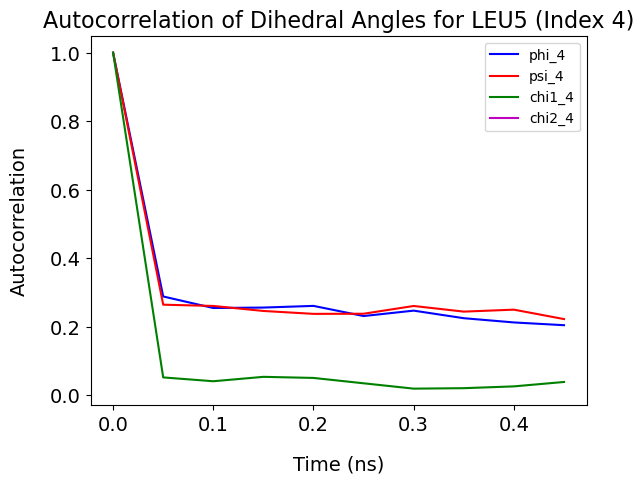

Residue ILE8 (Index 7)


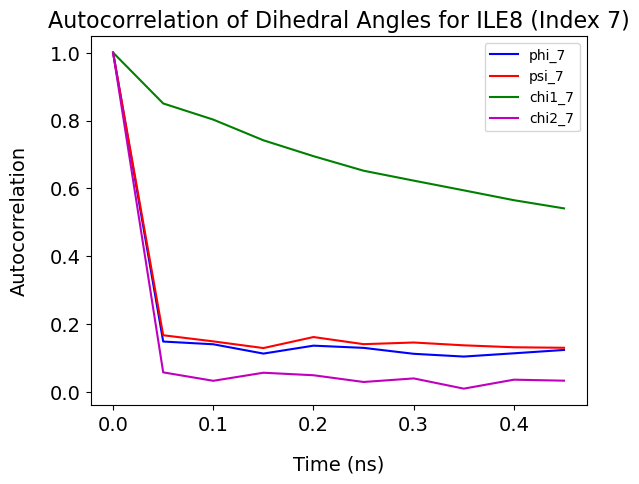

Residue TYR11 (Index 10)


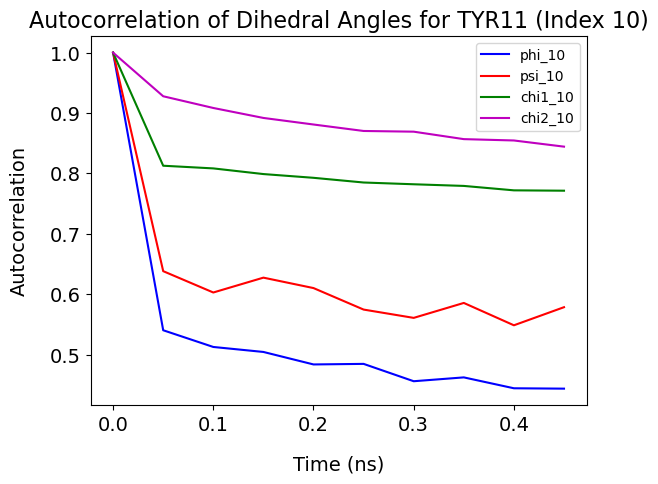

Residue HIS66 (Index 65)


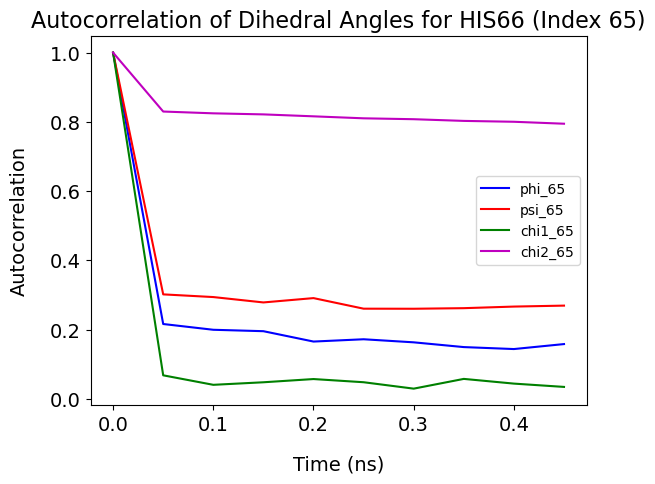

Residue TYR128 (Index 127)


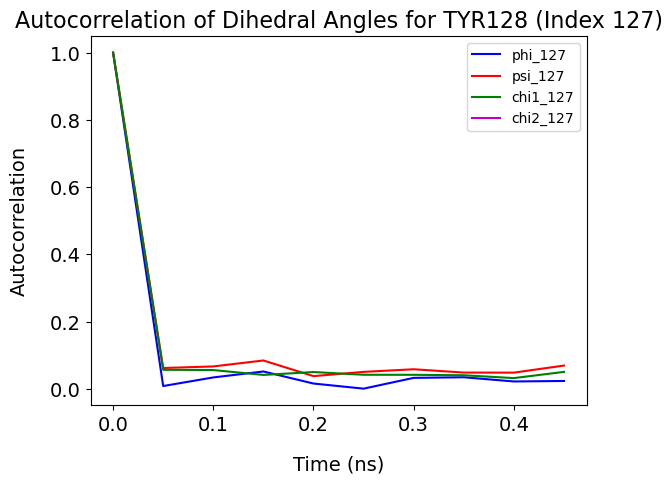

Residue TRP167 (Index 166)


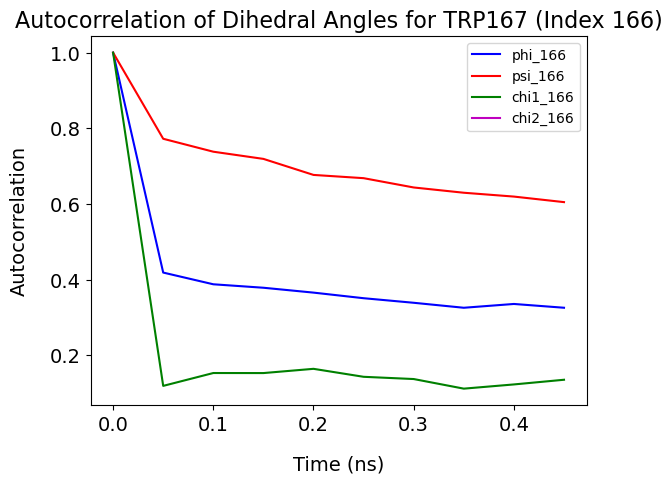

Residue ILE201 (Index 200)


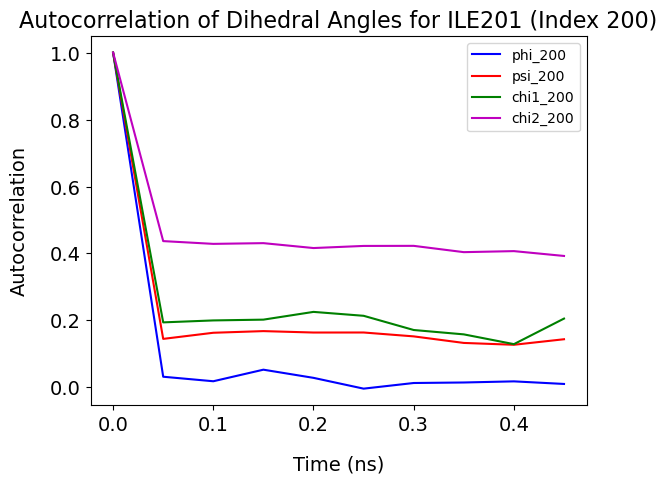

Residue ARG202 (Index 201)


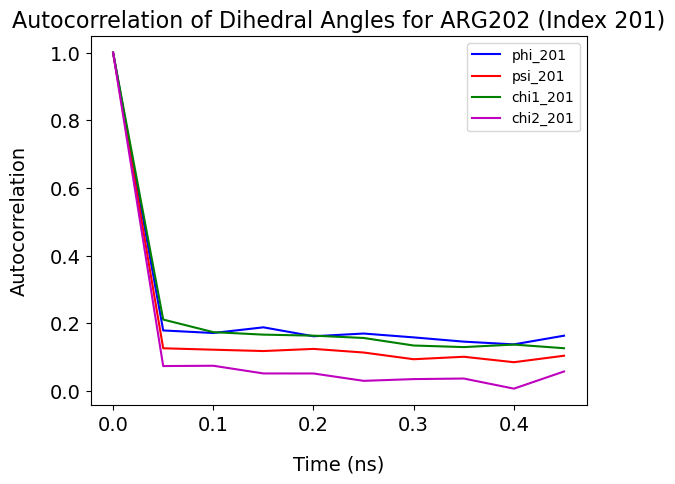

Residue GLU63 (Index 62)


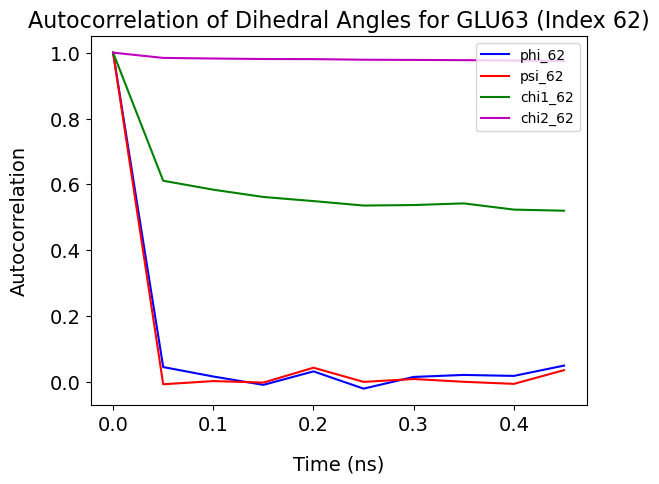

In [48]:
def autocorr1(x, lags):
    '''numpy.corrcoef, partial'''
    corr = [1. if l == 0 else np.corrcoef(x[l:], x[:-l])[0][1] for l in lags]
    return np.array(corr)

res_interest= [2, 4, 7, 10, 65, 127, 166, 200, 201, 62]
# Define time in microseconds
time = np.linspace(0, 300, trj.n_frames)
lags = range(10)  # Takes time series and correlates it to itself but lagged by 10 steps

# Function to get residue name and sequence number
def get_residue_info(residue_index, topology):
    residue = topology.residue(residue_index)
    return residue.name, residue.resSeq

# Iterate over each residue in array
for res in res_interest:
    resname, resnum = get_residue_info(res, trj.topology)
    print(f"Residue {resname}{resnum} (Index {res})")

    # Calculate autocorrelation for phi, psi, chi1, and chi2 for the current residue
    phi_acf = autocorr1(dihedral_dict['phi'].get(res, []), lags)
    psi_acf = autocorr1(dihedral_dict['psi'].get(res, []), lags)
    chi1_acf = autocorr1(dihedral_dict.get('chi1', {}).get(res, []), lags)
    chi2_acf = autocorr1(dihedral_dict.get('chi2', {}).get(res, []), lags)

    # Plot autocorrelation for each dihedral angle
    plt.plot(time[lags], phi_acf, color='b', label=f'phi_{res}')
    plt.plot(time[lags], psi_acf, color='r', label=f'psi_{res}')
    plt.plot(time[lags], chi1_acf, color='g', label=f'chi1_{res}')
    plt.plot(time[lags], chi2_acf, color='m', label=f'chi2_{res}')

    plt.xlabel("Time (ns)", size=14, labelpad=15)
    plt.ylabel("Autocorrelation", size=14, labelpad=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"Autocorrelation of Dihedral Angles for {resname}{resnum} (Index {res})", size=16)
    plt.legend()
    plt.show()
#This will get angry when it encounters residues that don't have all of the dihedral residues, but thats okay. I will ignore this. 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define autocorrelation function
def autocorr1(x, lags):
    '''numpy.corrcoef, partial'''
    corr = [1. if l == 0 else np.corrcoef(x[l:], x[:-l])[0][1] for l in lags]
    return np.array(corr)
auto_corr_time_dict = {}
# Iterate over each residue in residues array
for angle in dihedral_dict.keys():
    for residue in dihedral_dict[angle].keys():
        # Calculate autocorrelation for each dihedral angle
        angle_acf = autocorr1(dihedral_dict[angle].get(residue, np.zeros(trj.n_frames)), lags)
    
        # Define a linear function for regression
        def linear_func(t, m, c):
            return m * t + c

        # Perform linear regression for each autocorrelation curve using the first two lag values
        linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], angle_acf[:2])

        # Print the slopes
        print(f"Autocorrelation time for {angle} at residues {residue}: {-1/linfit_angle[0]}")
        if angle not in auto_corr_time_dict.keys(): \
            auto_corr_time_dict[angle]={}
        auto_corr_time_dict[angle][residue] = - 1/linfit_angle[0]
        

C:\Users\grace\AppData\Local\Temp\ipykernel_6148\2491910606.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], angle_acf[:2])


Autocorrelation time for phi at residues 2: 0.09762327723612589
Autocorrelation time for phi at residues 3: 0.08399296759973367
Autocorrelation time for phi at residues 4: 0.07030623258453823
Autocorrelation time for phi at residues 5: 0.07289679054404008
Autocorrelation time for phi at residues 6: 0.06670306742292266
Autocorrelation time for phi at residues 7: 0.058728989807194036
Autocorrelation time for phi at residues 8: 0.06120888322795624
Autocorrelation time for phi at residues 9: 0.11521291145214066
Autocorrelation time for phi at residues 10: 0.10880343430560313
Autocorrelation time for phi at residues 11: 0.14796484000239013
Autocorrelation time for phi at residues 12: 0.06258059348105517
Autocorrelation time for phi at residues 13: 0.05586176352805804
Autocorrelation time for phi at residues 14: 0.05209288639900292
Autocorrelation time for phi at residues 15: 0.07699231174004349
Autocorrelation time for phi at residues 16: 0.09578006298230173
Autocorrelation time for phi at 

C:\Users\grace\AppData\Local\Temp\ipykernel_6148\2407913966.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_, pcov_ = curve_fit(linear_func, time[lags][:2], np.log(dihedral_acf[:2]))


Residue phi_60 has correlation time longer than 0.8 microseconds: 1.1769912316050288 microseconds.
Residue psi_211 has correlation time longer than 0.8 microseconds: 1.1137642635936489 microseconds.
Residue chi1_12 has correlation time longer than 0.8 microseconds: 0.9083537662357524 microseconds.
Residue chi2_62 has correlation time longer than 0.8 microseconds: 3.1049680519840948 microseconds.
Residue chi2_124 has correlation time longer than 0.8 microseconds: 0.811374471500577 microseconds.
Residue chi2_141 has correlation time longer than 0.8 microseconds: 1.867078238146573 microseconds.
Residue chi2_247 has correlation time longer than 0.8 microseconds: 1.4101037289994702 microseconds.


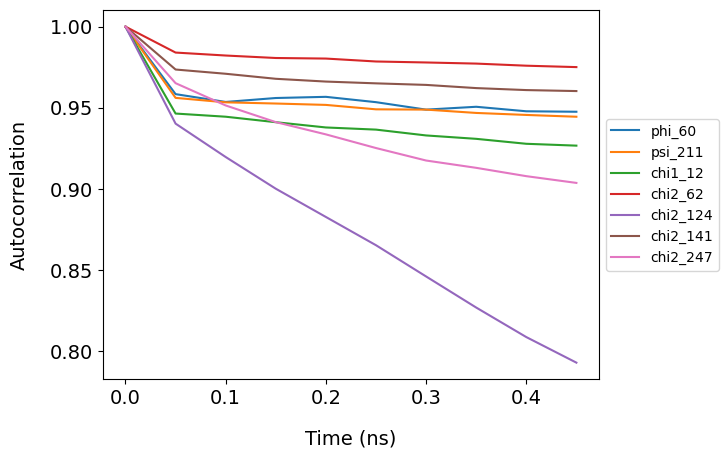

In [35]:
import numpy as np
import matplotlib.pyplot as plt
# Define threshold value here (in nanoseconds)
threshold = 0.8

residues_above_threshold = []
# Loop over all phi/psi/chi1/chi2 residues
for residue_type in ['phi', 'psi', 'chi1', 'chi2']:
    for residue_number, dihedral_data in dihedral_dict[residue_type].items():
        # Calculate autocorrelation for each dihedral angle
        dihedral_acf = autocorr1(dihedral_data, lags)
        # Calculate correlation time 
        correlation_time = 0
        if dihedral_acf[1] > 0:
            popt_, pcov_ = curve_fit(linear_func, time[lags][:2], np.log(dihedral_acf[:2]))
            correlation_time = -1/popt_[0]
            if correlation_time > threshold:
                residues_above_threshold.append((residue_type, residue_number, correlation_time))
                print(f"Residue {residue_type}_{residue_number} has correlation time longer than {threshold} microseconds: {correlation_time} microseconds.")
# Plotting only residues with correlation time greater than the threshold
for residue_type, residue_number, correlation_time in residues_above_threshold:
    dihedral_acf = autocorr1(dihedral_dict[residue_type][residue_number], lags)
    plt.plot(time[lags], dihedral_acf, label=f"{residue_type}_{residue_number}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Time (ns)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

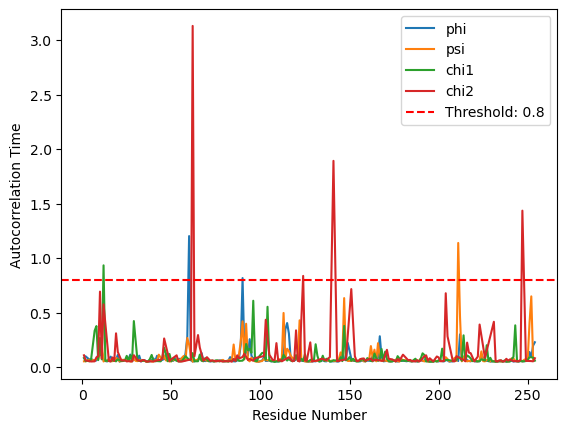

In [36]:
#This gives me a plot of the autocorrelation times for each dihedral angle for all residues. 
for angle in auto_corr_time_dict.keys(): 
    a_corr_arr = []
    residues = list(auto_corr_time_dict[angle].keys())
    for residue in residues:
        a_corr_arr.append(auto_corr_time_dict[angle][residue])
    plt.plot(residues, a_corr_arr, label=angle)
plt.legend()
plt.xlabel('Residue Number')  
plt.ylabel('Autocorrelation Time')  
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')  
plt.legend()
plt.show()

In [37]:
#Do this again for each PC states
PC_state1_auto_corr_time_dict = {}

# Iterate over each residue in residues array
for angle in dihedral_dict.keys():
    for residue in dihedral_dict[angle].keys():
        # Get dihedral data for the current angle and residue, and slice using PC_state1_indices
        dihedral_data = dihedral_dict[angle][residue]
        dihedral_data_pc_state1 = dihedral_data[PC_state1_indices]
        
        # Calculate autocorrelation for each dihedral angle
        angle_acf = autocorr1(dihedral_data_pc_state1, lags)
        
        # Check if the values in angle_acf[:2] are positive and non-zero
        if np.all(angle_acf[:2] > 0):
            # Define a linear function for regression
            def linear_func(t, m, c):
                return m * t + c

            # Perform linear regression for each autocorrelation curve using the first two lag values
            linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], np.log(angle_acf[:2]))

            # Print the slopes
            correlation_time = -1 / linfit_angle[0]
            print(f"Autocorrelation time for {angle} at residue {residue}: {correlation_time}")
            
            if angle not in PC_state1_auto_corr_time_dict:
                PC_state1_auto_corr_time_dict[angle] = {}
            PC_state1_auto_corr_time_dict[angle][residue] = correlation_time
print(PC_state1_auto_corr_time_dict)

C:\Users\grace\AppData\Local\Temp\ipykernel_6148\1937218375.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], np.log(angle_acf[:2]))


Autocorrelation time for phi at residue 2: 0.052320797644255936
Autocorrelation time for phi at residue 3: 0.05094089726684178
Autocorrelation time for phi at residue 4: 0.04054837349826475
Autocorrelation time for phi at residue 5: 0.047328862968641396
Autocorrelation time for phi at residue 6: 0.035781753102705136
Autocorrelation time for phi at residue 7: 0.022939739197839298
Autocorrelation time for phi at residue 8: 0.023481639683412544
Autocorrelation time for phi at residue 9: 0.03128901625986245
Autocorrelation time for phi at residue 10: 0.07930110058572293
Autocorrelation time for phi at residue 11: 0.08729639238861112
Autocorrelation time for phi at residue 12: 0.02383934421796803
Autocorrelation time for phi at residue 13: 0.023603867044813386
Autocorrelation time for phi at residue 14: 0.018795470743212226
Autocorrelation time for phi at residue 15: 0.05868587078233297
Autocorrelation time for phi at residue 16: 0.06477881348716624
Autocorrelation time for phi at residue 1

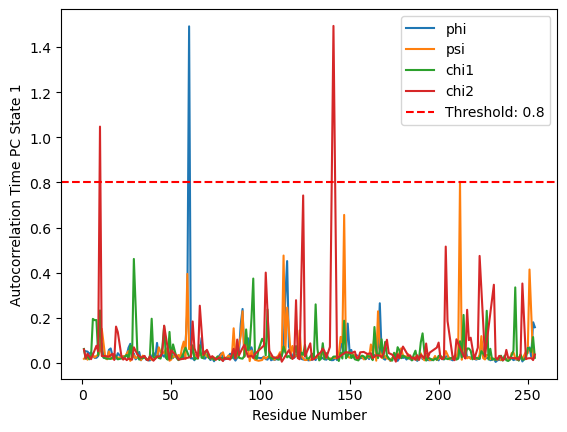

In [38]:
for angle in PC_state1_auto_corr_time_dict.keys(): 
    a_corr_arr = []
    residues = list(PC_state1_auto_corr_time_dict[angle].keys())
    for residue in residues:
        a_corr_arr.append(PC_state1_auto_corr_time_dict[angle][residue])
    plt.plot(residues, a_corr_arr, label=angle)
plt.legend()
plt.xlabel('Residue Number')  
plt.ylabel('Autocorrelation Time PC State 1')  
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')  # Add a horizontal line for the threshold
plt.legend()
plt.show()

In [39]:
#Do this again for each PC states
PC_state2_auto_corr_time_dict = {}

# Iterate over each residue in residues array
for angle in dihedral_dict.keys():
    for residue in dihedral_dict[angle].keys():
        # Get dihedral data for the current angle and residue, and slice using PC_state1_indices
        dihedral_data = dihedral_dict[angle][residue]
        dihedral_data_pc_state2 = dihedral_data[PC_state2_indices]
        
        # Calculate autocorrelation for each dihedral angle
        angle_acf = autocorr1(dihedral_data_pc_state2, lags)
        
        # Check if the values in angle_acf[:2] are positive and non-zero
        if np.all(angle_acf[:2] > 0):
            # Define a linear function for regression
            def linear_func(t, m, c):
                return m * t + c

            # Perform linear regression for each autocorrelation curve using the first two lag values
            linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], np.log(angle_acf[:2]))

            # Print the slopes
            correlation_time = -1 / linfit_angle[0]
            print(f"Autocorrelation time for {angle} at residue {residue}: {correlation_time}")
            
            # Add the calculated value to the dictionary
            if angle not in PC_state2_auto_corr_time_dict:
                PC_state2_auto_corr_time_dict[angle] = {}
            PC_state2_auto_corr_time_dict[angle][residue] = correlation_time

# Print the resulting dictionary for verification
print(PC_state2_auto_corr_time_dict)

C:\Users\grace\AppData\Local\Temp\ipykernel_6148\55895275.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], np.log(angle_acf[:2]))


Autocorrelation time for phi at residue 2: 0.046996616143818386
Autocorrelation time for phi at residue 3: 0.04335831697587332
Autocorrelation time for phi at residue 4: 0.031168383857910084
Autocorrelation time for phi at residue 5: 0.032337223121570544
Autocorrelation time for phi at residue 6: 0.03388828067957826
Autocorrelation time for phi at residue 7: 0.019113801064740536
Autocorrelation time for phi at residue 8: 0.01852421570807335
Autocorrelation time for phi at residue 9: 0.012896827902756437
Autocorrelation time for phi at residue 10: 0.06577861550903533
Autocorrelation time for phi at residue 11: 0.05665615321476918
Autocorrelation time for phi at residue 12: 0.023340774585205778
Autocorrelation time for phi at residue 13: 0.025576960874930475
Autocorrelation time for phi at residue 14: 0.03106653175360761
Autocorrelation time for phi at residue 15: 0.037447181830790856
Autocorrelation time for phi at residue 16: 0.06851334145676129
Autocorrelation time for phi at residue 

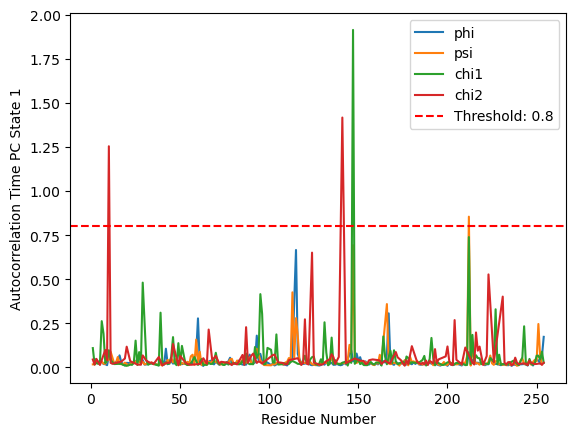

In [40]:
for angle in PC_state2_auto_corr_time_dict.keys(): 
    a_corr_arr = []
    residues = list(PC_state2_auto_corr_time_dict[angle].keys())
    for residue in residues:
        a_corr_arr.append(PC_state2_auto_corr_time_dict[angle][residue])
    plt.plot(residues, a_corr_arr, label=angle)
plt.legend()
plt.xlabel('Residue Number')  
plt.ylabel('Autocorrelation Time PC State 1')  
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')  # Add a horizontal line for the threshold
plt.legend()
plt.show()

In [41]:
PC_state3_auto_corr_time_dict = {}

# Iterate over each residue in residues array
for angle in dihedral_dict.keys():
    for residue in dihedral_dict[angle].keys():
        # Get dihedral data for the current angle and residue, and slice using PC_state1_indices
        dihedral_data = dihedral_dict[angle][residue]
        dihedral_data_pc_state3 = dihedral_data[PC_state3_indices]
        
        # Calculate autocorrelation for each dihedral angle
        angle_acf = autocorr1(dihedral_data_pc_state3, lags)
        
        # Check if the values in angle_acf[:2] are positive and non-zero
        if np.all(angle_acf[:2] > 0):
            # Define a linear function for regression
            def linear_func(t, m, c):
                return m * t + c

            # Perform linear regression for each autocorrelation curve using the first two lag values
            linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], np.log(angle_acf[:2]))

            # Print the slopes
            correlation_time = -1 / linfit_angle[0]
            print(f"Autocorrelation time for {angle} at residue {residue}: {correlation_time}")
            
            # Add the calculated value to the dictionary
            if angle not in PC_state3_auto_corr_time_dict:
                PC_state3_auto_corr_time_dict[angle] = {}
            PC_state3_auto_corr_time_dict[angle][residue] = correlation_time

# Print the resulting dictionary for verification
print(PC_state3_auto_corr_time_dict)

C:\Users\grace\AppData\Local\Temp\ipykernel_6148\2983814051.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  linfit_angle, _ = curve_fit(linear_func, time[lags[:2]], np.log(angle_acf[:2]))


Autocorrelation time for phi at residue 2: 0.1067477694927521
Autocorrelation time for phi at residue 3: 0.06211481837490864
Autocorrelation time for phi at residue 4: 0.036536107120155786
Autocorrelation time for phi at residue 5: 0.04615865139398181
Autocorrelation time for phi at residue 6: 0.029656639601120038
Autocorrelation time for phi at residue 7: 0.024672742330231402
Autocorrelation time for phi at residue 8: 0.023141845783608606
Autocorrelation time for phi at residue 9: 0.10198473195346527
Autocorrelation time for phi at residue 10: 0.054456023047098484
Autocorrelation time for phi at residue 11: 0.13299166652788091
Autocorrelation time for phi at residue 12: 0.017232770245655855
Autocorrelation time for phi at residue 13: 0.025149223525569923
Autocorrelation time for phi at residue 14: 0.029158124591302216
Autocorrelation time for phi at residue 15: 0.026943919923458338
Autocorrelation time for phi at residue 16: 0.10151270097883076
Autocorrelation time for phi at residue 

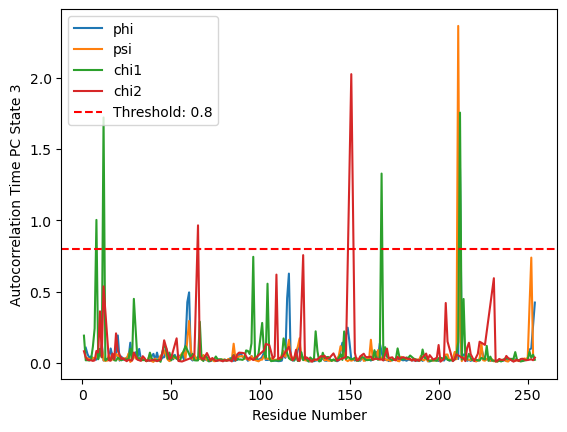

In [42]:
for angle in PC_state3_auto_corr_time_dict.keys(): 
    a_corr_arr = []
    residues = list(PC_state3_auto_corr_time_dict[angle].keys())
    for residue in residues:
        a_corr_arr.append(PC_state3_auto_corr_time_dict[angle][residue])
    plt.plot(residues, a_corr_arr, label=angle)
plt.legend()
plt.xlabel('Residue Number')  
plt.ylabel('Autocorrelation Time PC State 3')  
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')  # Add a horizontal line for the threshold
plt.legend()
plt.show()

Identify trends in dihedral angles across frames for residues of interest.

Residue LEU3 (Index 2)


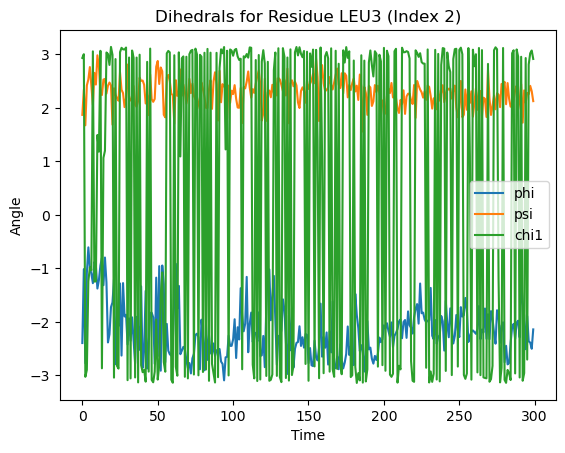

Residue LEU5 (Index 4)


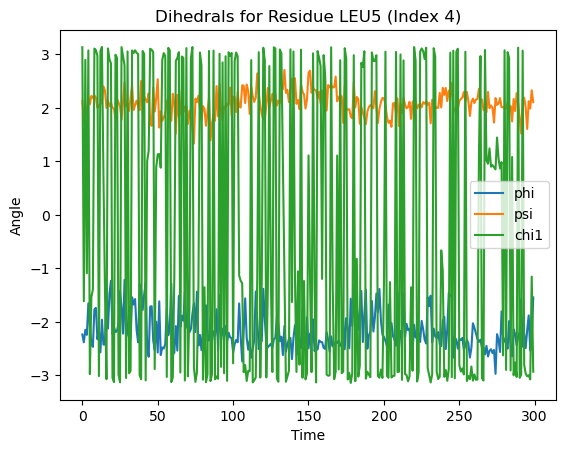

Residue ILE8 (Index 7)


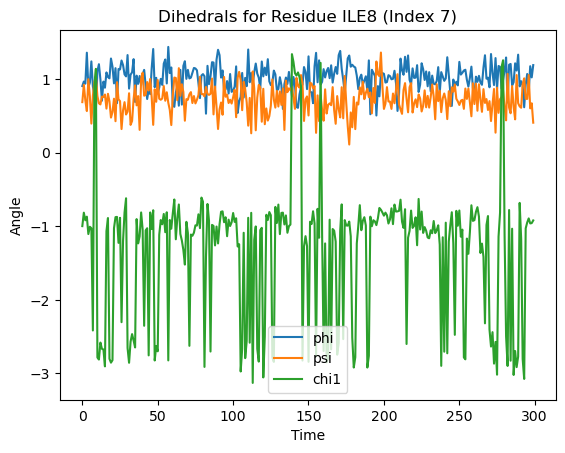

Residue TYR11 (Index 10)


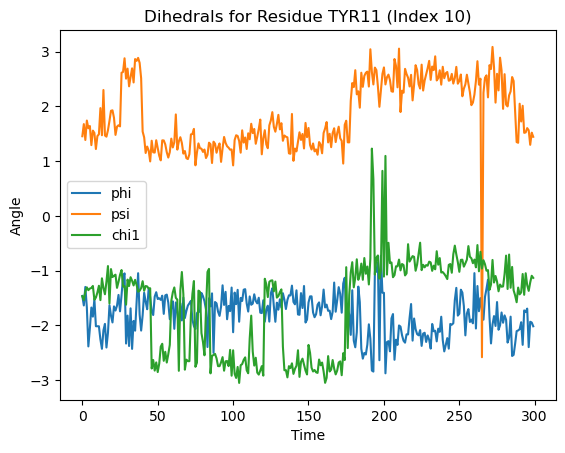

Residue HIS66 (Index 65)


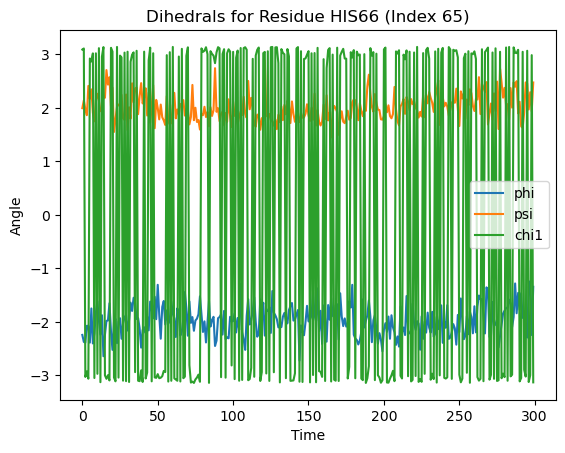

Residue TYR128 (Index 127)


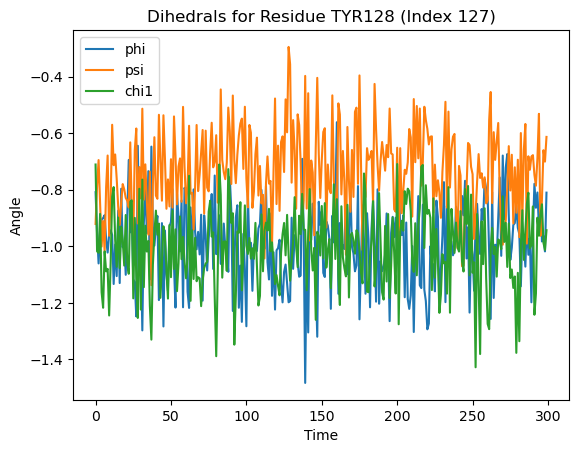

Residue TRP167 (Index 166)


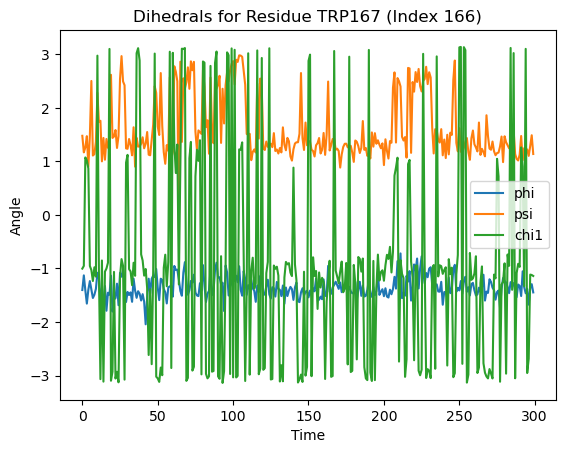

Residue ILE201 (Index 200)


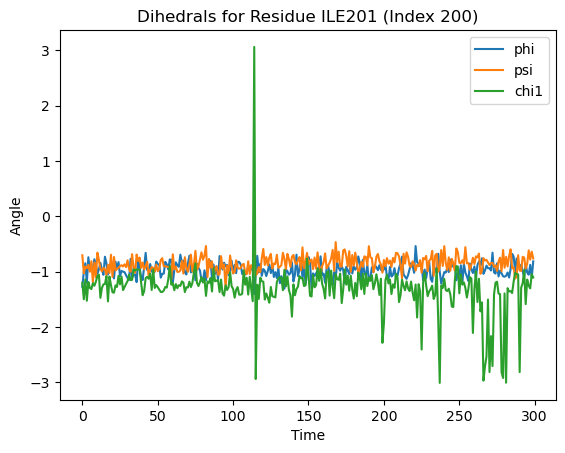

Residue ARG202 (Index 201)


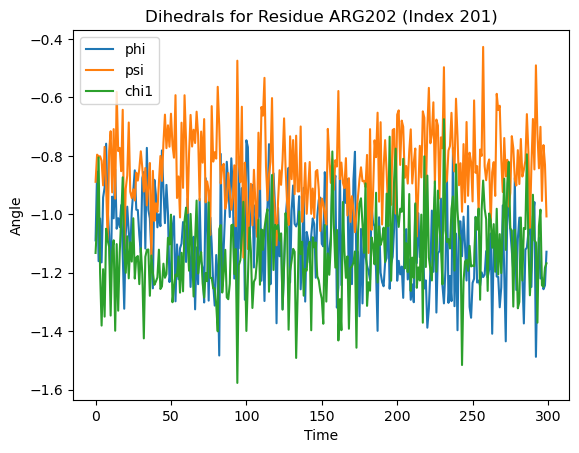

Residue VAL64 (Index 63)


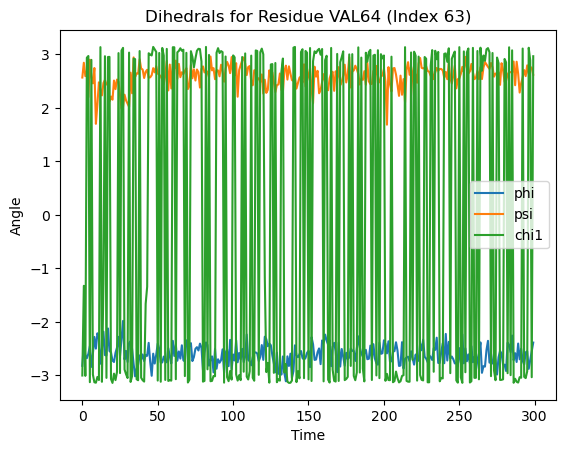

In [43]:
# Function to get residue name and sequence number
def get_residue_info(residue_index, topology):
    residue = topology.residue(residue_index)
    return residue.name, residue.resSeq

for res in res_interest:
    resname, resnum = get_residue_info(res, trj.topology)
    print(f"Residue {resname}{resnum} (Index {res})")
    
    plt.plot(time[::20], dihedral_dict['phi'][res][::20], label="phi")
    plt.plot(time[::20], dihedral_dict['psi'][res][::20], label="psi")
    plt.plot(time[::20], dihedral_dict['chi1'][res][::20], label="chi1")

    plt.xlabel('Time')
    plt.ylabel('Angle')
    plt.title(f'Dihedrals for Residue {resname}{resnum} (Index {res})')
    plt.legend()
    plt.show()

Plot RMSD vs delta G. This is not very informative since there are minimal shifts in RMSD.

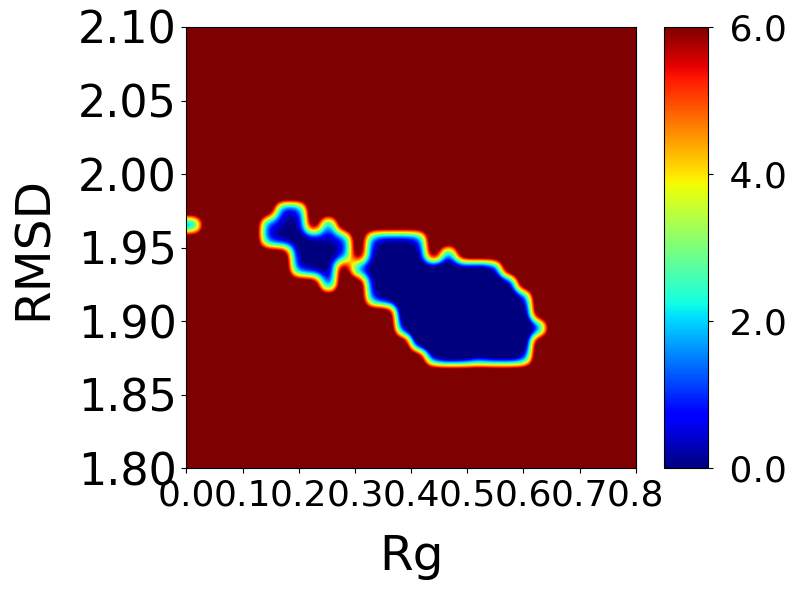

In [44]:
dG,xedges,yedges=free_energy(rg, rmsd, 300, 1.8, 2.1, 0, 0.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,2,4,6]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0, vmax=6.0)
plt.yticks(size='26')
plt.tight_layout()

In [45]:
#Here I am defining all the functions for my block errors
import pyblock
from itertools import chain
def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error

def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out


def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    # free_energy=-(0.001987*T)*np.log(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr

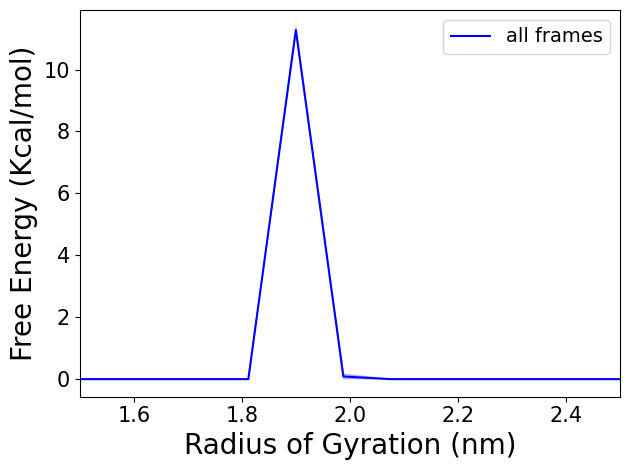

In [46]:
Rg_all, edges, u_err = histo_blockerror(rg, 0.8, 3.0, 25, 5)

plt.plot(edges, Rg_all, c='blue', label='all frames')
plt.fill_between(edges, Rg_all-u_err, Rg_all+u_err, color='blue', alpha=0.2)

plt.xlim(1.5, 2.5)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()

Plot Rg as a funciton of delta G. Get a sense for relative structural flexibility and stability across protein- ligand complexes.

C:\Users\grace\AppData\Local\Temp\ipykernel_6148\3111160101.py:54: RuntimeWarning: invalid value encountered in divide
  ferr = -(0.001987*T)*(error / average)


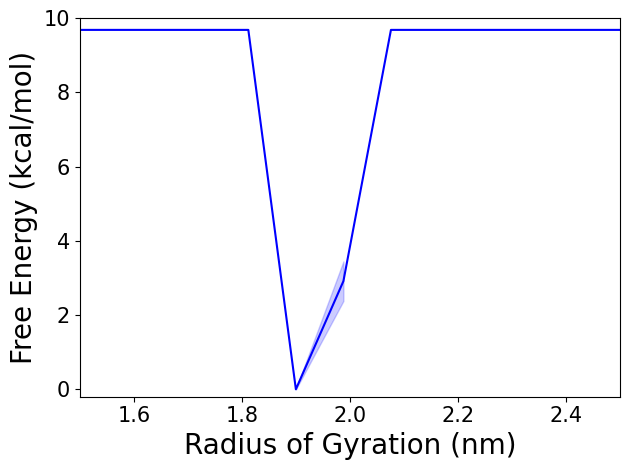

In [47]:
dG, bin_centers, ferr = free_energy_1D_blockerror(rg, 300, 0.8, 3.0, 25, 5)
sns.lineplot(x=bin_centers, y=dG, color='blue')
plt.fill_between(bin_centers, dG-ferr, dG+ferr, color='blue', alpha=0.2)
plt.ylim(-0.2, 10)
plt.xlim(1.5, 2.5)
plt.xlabel('Radius of Gyration (nm)', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
np.savetxt(outdir+'RegA_MYS_rg.dG.err.dat', np.column_stack((bin_centers, dG, ferr)))
plt.tight_layout()
plt.savefig('%s/Rg.dG.pdf' % outdir)
plt.show()
